In [1]:
import sys
sys.path.append(r'H:\My Drive\2022\GitHub\pyMELTScalc\MELTS')
from meltsdynamic import MELTSdynamic
from meltsengine import MELTSengine
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from meltsplotter import MELTSplotter
import sys, os
import shutil
import tempfile
from collections import OrderedDict
from pathlib import Path
import deepdish as dd
import itertools
%matplotlib inline
import time
import random
import pyMELTScalc as M
import re
from matplotlib.cm import get_cmap
from cmcrameri import cm
import Thermobar as pt
import distinctipy
import PySulfSat as ss

In [368]:
M.__version__

'0.0.12'

In [369]:
ss.__version__

'0.0.7'

In [370]:
Comp = {'SiO2_Liq': 49.2,
         'TiO2_Liq': 0.69,
         'Al2O3_Liq': 12.9,
         'FeOt_Liq': 9.9596,
         'MgO_Liq': 12.93,
         'CaO_Liq': 11.21,
         'Na2O_Liq': 1.99,
         'K2O_Liq': 0.97,
         'MnO_Liq': 0.2,
         'P2O5_Liq': 0.2,
         'H2O_Liq': 1.0,
         'CO2_Liq': 0.1,
       'Fe3Fet_Liq': 0.25}

In [377]:
file = pd.read_csv('/Users/ollie/Documents/Cambridge_2020/Earth_Sciences/MELTs/pyMELTScalc-master/Examples/CrystallisationTests/SchmidtVan_scss.csv')
#file = pd.read_csv('/Users/ollie/Documents/Cambridge_2020/Earth_Sciences/Paper_2/FC_simulations/Metrich_Tan2318.csv')
#file = pd.read_csv('/Users/ollie/Rhiannon_MELTS/StVincbulks.csv')
#file = pd.read_csv('/Users/ollie/Rhiannon_MELTS/gleeson_azorestest.csv')
header = file.columns.values.tolist()
file

,P,Temp,FMQ,CO2,SiO2,TiO2,Al2O3,FeO,Fe2O3,MgO,...,Na2O,K2O,MnO,P2O5,H2O,Cr2O5,NiO,Ni,Cu,FeOt
0,2000,1350,0,0.1,49.2,0.69,12.9,7.2689,2.6907,12.93,...,1.99,0.97,0.2,0.2,1,0,0,20,30,9.9596


Metrich initial is very Al2O3 rich, likely not primtive so have used Schmidt and Jagoutz average for Van arc.

In [381]:
bulk = file.iloc[0].values.tolist()

h2o = [1.0, 2.0]
#co2 = [0.1] #0.01, using jsut one CO2 variation because made little difference to FC runs 
emptydf = pd.DataFrame()

for i in range(len(h2o)):
    bulk[15] = h2o[i]
   # for j in range(len(co2)):
   #     bulk[3] = co2[j]
    emptydf = emptydf.append(pd.DataFrame([bulk]), ignore_index=True)

emptydf.columns = header
emptydf = emptydf[['SiO2', 'TiO2', 'Al2O3','FeOt', 'MgO', 'CaO', 'Na2O', 'K2O','MnO', 'P2O5','CO2', 'H2O']]#,]], 
emptydf

,SiO2,TiO2,Al2O3,FeOt,MgO,CaO,Na2O,K2O,MnO,P2O5,CO2,H2O
0,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,0.1,1.0
1,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,0.1,2.0


### Part 2: Thermobar calcs: FeO Fe2O3 ratios for buffered or unbuffered compositions


In [382]:
emptydf.columns = [str(col) + '_Liq' for col in emptydf.columns]
# Next steps are to calculate the redox state of the initial melt series
emptydf['Sample_ID_Liq'] = emptydf.index
# Fe3Fet_Liq buffer is Temperature dependent so calc T
T_HT87=pt.calculate_liq_only_temp(liq_comps=emptydf, equationT='T_Helz1987_MgO')
# gives 1547.043 K (1274 C)

In [383]:
# For a known buffer e.g. QFM+1, issue is fixed pressure 
myLiquids_Fe3_Kress_norm_QFM1=pt.convert_fo2_to_fe_partition(liq_comps=emptydf, T_K=T_HT87,
                            P_kbar=2, fo2="QFM",fo2_offset=1, model="Kress1991", renorm=True) #check pkbar
myLiquids_Fe3_Kress_norm_QFM1['buffer'] = 'QFM_1' #change back to 1
myLiquids_Fe3_Kress_norm_QFM1[['H2O_Liq']] = emptydf[['H2O_Liq']] #,'CO2_Liq','CO2_Liq'

In [384]:
myLiquids_Fe3_Kress_norm_QFM1

,SiO2_Liq,TiO2_Liq,Al2O3_Liq,Fe2O3_Liq,FeO_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,Fe3Fet_Liq,buffer,H2O_Liq
0,49.62147,0.695914,13.010572,2.414371,7.871308,0.201714,13.040829,11.306086,2.007057,0.978314,0.201714,0.216299,QFM_1,1.0
1,50.11168,0.702789,13.139104,2.425865,7.960194,0.203707,13.169660,11.417779,2.026885,0.987979,0.203707,0.215202,QFM_1,2.0


In [385]:
myLiquids_Fe3_Kress_norm_QFM=pt.convert_fo2_to_fe_partition(liq_comps=emptydf, T_K=T_HT87,
                            P_kbar=2, fo2="QFM", model="Kress1991", renorm=True)
myLiquids_Fe3_Kress_norm_QFM['buffer'] = 'QFM'
myLiquids_Fe3_Kress_norm_QFM[['H2O_Liq']] = emptydf[['H2O_Liq']] #,'CO2_Liq','CO2_Liq'

In [386]:
myLiquids_Fe3_Kress_norm_QFM

,SiO2_Liq,TiO2_Liq,Al2O3_Liq,Fe2O3_Liq,FeO_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,Fe3Fet_Liq,buffer,H2O_Liq
0,49.657900,0.696425,13.020124,1.669830,8.548994,0.201862,13.050404,11.314387,2.008531,0.979033,0.201862,0.149481,QFM,1.0
1,50.148319,0.703303,13.148710,1.677049,8.641771,0.203856,13.179289,11.426127,2.028367,0.988701,0.203856,0.148659,QFM,2.0


In [11]:
myLiquids_Fe3_Kress_norm_NNO=pt.convert_fo2_to_fe_partition(liq_comps=emptydf, T_K=T_HT87,
                            P_kbar=2, fo2="NNO", model="Kress1991", renorm=True)
myLiquids_Fe3_Kress_norm_NNO['buffer'] = 'NNO'
myLiquids_Fe3_Kress_norm_NNO[['H2O_Liq']] = emptydf[['H2O_Liq']] #,'CO2_Liq','CO2_Liq'

In [12]:
myLiquids_Fe3_Kress_norm_NNO

,SiO2_Liq,TiO2_Liq,Al2O3_Liq,Fe2O3_Liq,FeO_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,Fe3Fet_Liq,buffer,H2O_Liq
0,49.586441,0.695423,13.001388,2.127251,8.122712,0.201572,13.031624,11.298105,2.005640,0.977624,0.201572,0.190708,NNO,1.0
1,50.076735,0.702299,13.129941,2.137042,8.213148,0.203565,13.160476,11.409817,2.025472,0.987290,0.203565,0.189710,NNO,2.0


In [387]:
unbuff = emptydf.copy()
unbuff['Fe3Fet_Liq'] = 0.25 
unbuff['buffer'] = 'unbuffered'
unbuff

,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,MnO_Liq,P2O5_Liq,CO2_Liq,H2O_Liq,Sample_ID_Liq,Fe3Fet_Liq,buffer
0,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,0.1,1.0,0,0.25,unbuffered
1,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,0.1,2.0,1,0.25,unbuffered


### Option to merge starting compositions with different fo2 conditions 

In [388]:
# merge dataframes ready for MELTS simulations - for practice just use 2 to save time
merged = pd.concat([myLiquids_Fe3_Kress_norm_QFM,myLiquids_Fe3_Kress_norm_QFM1,unbuff,],ignore_index=True) #,myLiquids_Fe3_Kress_norm_NNO,,]
merged


,SiO2_Liq,TiO2_Liq,Al2O3_Liq,Fe2O3_Liq,FeO_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,Fe3Fet_Liq,buffer,H2O_Liq,FeOt_Liq,CO2_Liq,Sample_ID_Liq
0,49.657900,0.696425,13.020124,1.669830,8.548994,0.201862,13.050404,11.314387,2.008531,0.979033,0.201862,0.149481,QFM,1.0,NaN,NaN,NaN
1,50.148319,0.703303,13.148710,1.677049,8.641771,0.203856,13.179289,11.426127,2.028367,0.988701,0.203856,0.148659,QFM,2.0,NaN,NaN,NaN
2,49.621470,0.695914,13.010572,2.414371,7.871308,0.201714,13.040829,11.306086,2.007057,0.978314,0.201714,0.216299,QFM_1,1.0,NaN,NaN,NaN
3,50.111680,0.702789,13.139104,2.425865,7.960194,0.203707,13.169660,11.417779,2.026885,0.987979,0.203707,0.215202,QFM_1,2.0,NaN,NaN,NaN
4,49.200000,0.690000,12.900000,NaN,NaN,0.200000,12.930000,11.210000,1.990000,0.970000,0.200000,0.250000,unbuffered,1.0,9.9596,0.1,0.0
5,49.200000,0.690000,12.900000,NaN,NaN,0.200000,12.930000,11.210000,1.990000,0.970000,0.200000,0.250000,unbuffered,2.0,9.9596,0.1,1.0


In [389]:
# Making sure that FeOt is filled:
#merged['FeOt_Liq'] = merged['Fe2O3_Liq'] + merged['FeO_Liq']
merged['FeOt_Liq'] = np.where(merged['FeOt_Liq'].isnull(), merged['Fe2O3_Liq'] + merged['FeO_Liq'],merged['FeOt_Liq'])
merged


,SiO2_Liq,TiO2_Liq,Al2O3_Liq,Fe2O3_Liq,FeO_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,Fe3Fet_Liq,buffer,H2O_Liq,FeOt_Liq,CO2_Liq,Sample_ID_Liq
0,49.657900,0.696425,13.020124,1.669830,8.548994,0.201862,13.050404,11.314387,2.008531,0.979033,0.201862,0.149481,QFM,1.0,10.218824,NaN,NaN
1,50.148319,0.703303,13.148710,1.677049,8.641771,0.203856,13.179289,11.426127,2.028367,0.988701,0.203856,0.148659,QFM,2.0,10.318820,NaN,NaN
2,49.621470,0.695914,13.010572,2.414371,7.871308,0.201714,13.040829,11.306086,2.007057,0.978314,0.201714,0.216299,QFM_1,1.0,10.285680,NaN,NaN
3,50.111680,0.702789,13.139104,2.425865,7.960194,0.203707,13.169660,11.417779,2.026885,0.987979,0.203707,0.215202,QFM_1,2.0,10.386060,NaN,NaN
4,49.200000,0.690000,12.900000,NaN,NaN,0.200000,12.930000,11.210000,1.990000,0.970000,0.200000,0.250000,unbuffered,1.0,9.959600,0.1,0.0
5,49.200000,0.690000,12.900000,NaN,NaN,0.200000,12.930000,11.210000,1.990000,0.970000,0.200000,0.250000,unbuffered,2.0,9.959600,0.1,1.0


### Part 3: Add an indexing column including initial parameters that are input to alphaMELTS

##### Note that MELTS reads in FeOt column therefore the Fe3Fet_liq value is essential for input. 

In [390]:
merged['dictindex'] = 'H2O_' + merged['H2O_Liq'].astype(str)  + '_' 'buff_' + merged['buffer'] #+ '_' 'CO2_' + merged['CO2_Liq'].astype(str)

MELTS_iter = merged[['SiO2_Liq', 'TiO2_Liq', 'Al2O3_Liq', 'Fe2O3_Liq', 'FeO_Liq','FeOt_Liq', 'MgO_Liq', 'CaO_Liq',
       'Na2O_Liq','K2O_Liq', 'K2O_Liq', 'P2O5_Liq', 'H2O_Liq','Fe3Fet_Liq', 
       'dictindex']] #'CO2_Liq',

Comp = MELTS_iter.copy()
Comp #note that row number is the number of unique MELTS inputs 

,SiO2_Liq,TiO2_Liq,Al2O3_Liq,Fe2O3_Liq,FeO_Liq,FeOt_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,K2O_Liq,P2O5_Liq,H2O_Liq,Fe3Fet_Liq,dictindex
0,49.657900,0.696425,13.020124,1.669830,8.548994,10.218824,13.050404,11.314387,2.008531,0.979033,0.979033,0.201862,1.0,0.149481,H2O_1.0_buff_QFM
1,50.148319,0.703303,13.148710,1.677049,8.641771,10.318820,13.179289,11.426127,2.028367,0.988701,0.988701,0.203856,2.0,0.148659,H2O_2.0_buff_QFM
2,49.621470,0.695914,13.010572,2.414371,7.871308,10.285680,13.040829,11.306086,2.007057,0.978314,0.978314,0.201714,1.0,0.216299,H2O_1.0_buff_QFM_1
3,50.111680,0.702789,13.139104,2.425865,7.960194,10.386060,13.169660,11.417779,2.026885,0.987979,0.987979,0.203707,2.0,0.215202,H2O_2.0_buff_QFM_1
4,49.200000,0.690000,12.900000,NaN,NaN,9.959600,12.930000,11.210000,1.990000,0.970000,0.970000,0.200000,1.0,0.250000,H2O_1.0_buff_unbuffered
5,49.200000,0.690000,12.900000,NaN,NaN,9.959600,12.930000,11.210000,1.990000,0.970000,0.970000,0.200000,2.0,0.250000,H2O_2.0_buff_unbuffered


Fe3Fet_Liq: float or np.ndarray
        Fe 3+/total ratio. If type(comp) == dict, and type(Fe3Fet_Liq) == np.ndarray a new DataFrame will be constructed with bulk compositions varying only in their Fe3Fet_Liq value. If comp is a pd.DataFrame, a single Fe3Fet_Liq value may be passed (float) and will be used as the Fe redox state for all starting compostions, or an array of Fe3Fet_Liq values, equal to the number of compositions specified in comp can specify a different Fe redox state for each sample. 
        
If None, the Fe redox state must be specified in the comp variable or an oxygen fugacity buffer must be chosen.

In [ ]:
# run only for single pressures

P = 1000
H2O_Liq = [0.5, 1.0, 2.33333333, 3.66666667, 5.0]
Results = M.multi_path(Model = "MELTSv1.2.0", comp = Comp, Frac_solid = True, Frac_fluid = True, 
                       T_end_C = 800, dt_C = 5, P_bar = P, Fe3Fet_Liq = 0.15, H2O_Liq = H2O_Liq, find_liquidus = True)

In [391]:
P_lin = ([2000.0,1000.0,500.0]) #np.array([2000.0, 4000.0]) doesnt work

P_results = {}
for i in range(len(P_lin)):
    P_bar = P_lin[i]
    print(P_bar)
    Results = M.multi_path(cores=4,Model = "MELTSv1.2.0", comp = Comp, Frac_solid = True, Frac_fluid = True, T_end_C = 700, dt_C = 5,
                      P_bar = P_bar, Fe3Fet_Liq = None, H2O_Liq = None, find_liquidus = True)

    P_results['P = ' + str(P_lin[i]) + ' bars'] = Results

2000.0


Running MELTSv1.2.0 calculations 0 to 3.0 ... Complete (time taken = 8.87 seconds)
Running MELTSv1.2.0 calculations 4 to 5.0 ... Complete (time taken = 6.31 seconds)

1000.0


Running MELTSv1.2.0 calculations 0 to 3.0 ... Complete (time taken = 6.95 seconds)
Running MELTSv1.2.0 calculations 4 to 5.0 ... Complete (time taken = 6.14 seconds)

500.0


Running MELTSv1.2.0 calculations 0 to 3.0 ... Complete (time taken = 6.36 seconds)
Running MELTSv1.2.0 calculations 4 to 5.0 ... Complete (time taken = 5.93 seconds)



In [392]:
P_results.keys()

dict_keys(['P = 2000.0 bars', 'P = 1000.0 bars', 'P = 500.0 bars'])

In [395]:
P_results['P = 2000.0 bars'].keys()

dict_keys(['index = 0', 'index = 1', 'index = 3', 'index = 2', 'index = 5', 'index = 4'])

### Part 4: Compile all unique outputs into a single dataframe 

# for a single pressure 
empty = pd.DataFrame() 

for key in Results:
    new = Results[key]['All']

    new['dict_index'] = key
    #new[['pressure_bar', 'T_C']] = final_dict[key]['Conditions'][['P_bar','T_C']]
    empty = empty.append(new)
empty.dict_index.unique()

In [396]:
empty = pd.DataFrame() 

for key in P_results:
    # p_dict is a dictionary of a single pressure 
    p_dict = P_results[key]
    final_dict = p_dict
    for key in final_dict:
        new = final_dict[key]['All']
        new['dict_index'] = key
        new[['pressure_bar', 'T_C']] = final_dict[key]['Conditions'][['P_bar','T_C']]
        empty = empty.append(new)
empty.dict_index.unique()

array(['index = 0', 'index = 1', 'index = 3', 'index = 2', 'index = 5',
       'index = 4'], dtype=object)

In [397]:
empty.dict_index

0     index = 0
1     index = 0
2     index = 0
3     index = 0
4     index = 0
        ...    
93    index = 5
94    index = 5
95    index = 5
96    index = 5
97    index = 5
Name: dict_index, Length: 1943, dtype: object

In [398]:
# replace dict_index values with H2O_CO2_fo2 identifiers

MELTS_iter['index'] = MELTS_iter.index #caveats w this format, change 
newkeys = MELTS_iter[['index','dictindex']]
newkeys

<ipython-input-398-03566c99aa98>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MELTS_iter['index'] = MELTS_iter.index #caveats w this format, change


,index,dictindex
0,0,H2O_1.0_buff_QFM
1,1,H2O_2.0_buff_QFM
2,2,H2O_1.0_buff_QFM_1
3,3,H2O_2.0_buff_QFM_1
4,4,H2O_1.0_buff_unbuffered
5,5,H2O_2.0_buff_unbuffered


In [399]:
empty_index = empty.reset_index()

In [400]:
empty_index['newentry'] = empty_index['dict_index'].str.extract('(\d+)')
empty_index['newentry'] 

0       0
1       0
2       0
3       0
4       0
       ..
1938    5
1939    5
1940    5
1941    5
1942    5
Name: newentry, Length: 1943, dtype: object

In [401]:
empty_index['newcolumn'] = 0
for i in range(len(empty_index)):
    empty_index['newentry'][i] = float(empty_index['newentry'][i])
    empty_index['newcolumn'][i] = newkeys['dictindex'][empty_index['newentry'][i]]
empty_index.shape

<ipython-input-401-69e151919c31>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_index['newentry'][i] = float(empty_index['newentry'][i])
<ipython-input-401-69e151919c31>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_index['newcolumn'][i] = newkeys['dictindex'][empty_index['newentry'][i]]
/Users/ollie/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  se

(1943, 290)

In [402]:
empty_index['unique'] = 'P_'+ empty_index['P_bar'].astype(str) + '_' + empty_index['newcolumn'].astype(str)

empty_index.newcolumn.unique(), empty_index.unique.unique() #if run at 2 pressures there should be double the categories of newcolumn


(array(['H2O_1.0_buff_QFM', 'H2O_2.0_buff_QFM', 'H2O_2.0_buff_QFM_1',
        'H2O_1.0_buff_QFM_1', 'H2O_2.0_buff_unbuffered',
        'H2O_1.0_buff_unbuffered'], dtype=object),
 array(['P_2000.0_H2O_1.0_buff_QFM', 'P_2000.0_H2O_2.0_buff_QFM',
        'P_2000.0_H2O_2.0_buff_QFM_1', 'P_2000.0_H2O_1.0_buff_QFM_1',
        'P_2000.0_H2O_2.0_buff_unbuffered',
        'P_2000.0_H2O_1.0_buff_unbuffered', 'P_1000.0_H2O_2.0_buff_QFM',
        'P_1000.0_H2O_1.0_buff_QFM', 'P_1000.0_H2O_1.0_buff_QFM_1',
        'P_1000.0_H2O_2.0_buff_QFM_1', 'P_1000.0_H2O_1.0_buff_unbuffered',
        'P_1000.0_H2O_2.0_buff_unbuffered', 'P_500.0_H2O_2.0_buff_QFM_1',
        'P_500.0_H2O_2.0_buff_QFM', 'P_500.0_H2O_1.0_buff_QFM',
        'P_500.0_H2O_1.0_buff_QFM_1', 'P_500.0_H2O_1.0_buff_unbuffered',
        'P_500.0_H2O_2.0_buff_unbuffered'], dtype=object))

### Part 5: Export master dataframe. Read in for following steps to reduce computer power. Unless we want to amend the data up to this point

In [403]:
# version 1.2.0 simulations
#empty_index.to_excel('/Users/ollie/Documents/Cambridge_2020/Earth_Sciences/Paper_2/FC_simulations/Schmidt_FC_pyMELTcalc_1.0.2_50.xlsx')
empty_index.to_excel('/Users/ollie/Documents/Cambridge_2020/Earth_Sciences/Paper_2/FC_simulations/Schmidt_FC_pyMELTcalc_1.2.0_All_Jan.xlsx')

In [2]:
#empty_na = pd.read_excel('/Users/ollie/Documents/Cambridge_2020/Earth_Sciences/Paper_2/FC_simulations/Schmidt_FC_pyMELTcalc_output.xlsx', index_col=0)
#empty_na_shall = pd.read_excel('/Users/ollie/Documents/Cambridge_2020/Earth_Sciences/Paper_2/FC_simulations/Schmidt_FC_pyMELTcalc_output_shall.xlsx', index_col=0)
empty_na = pd.read_excel('/Users/ollie/Documents/Cambridge_2020/Earth_Sciences/Paper_2/FC_simulations/Schmidt_FC_pyMELTcalc_1.2.0_All_Jan.xlsx', index_col=0)

# Version 1.2.0 simulations
#empty_index.to_excel('/Users/ollie/Rhiannon_MELTS/FC_simulation_output.xlsx') #go to bottom of notebook
#empty_index.to_excel('/Users/ollie/Rhiannon_MELTS/gleesonFC_simulation_output.xlsx')
empty_index.to_excel('/Users/ollie/Documents/Cambridge_2020/Earth_Sciences/Paper_2/FC_simulations/Schmidt_FC_pyMELTcalc_output_shall.xlsx')

empty_na = pd.read_excel('/Users/ollie/Documents/Cambridge_2020/Earth_Sciences/Paper_2/FC_simulations/Schmidt_FC_pyMELTcalc_output.xlsx', index_col=0)
empty_na_shall = pd.read_excel('/Users/ollie/Documents/Cambridge_2020/Earth_Sciences/Paper_2/FC_simulations/Schmidt_FC_pyMELTcalc_output_shall.xlsx', index_col=0)


In [3]:
empty_na.shape#, empty_na_shall.shape

(1943, 291)

In [4]:
empty_index = pd.concat([empty_na], axis=0,ignore_index=True)#,empty_na_shall
empty_index

,index,T_C,P_bar,h,s,v,SiO2_Liq,TiO2_Liq,Al2O3_Liq,Cr2O3_Liq,...,H2O_tridymite1,CO2_tridymite1,Fe3Fet_tridymite1,h_tridymite1,mass_tridymite1,v_tridymite1,rho_tridymite1,newentry,newcolumn,unique
0,0,1301.600000,2000,-1.196753e+06,286.026562,37.741464,48.533599,0.680658,12.725336,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_1.0_buff_QFM,P_2000.0_H2O_1.0_buff_QFM
1,1,1296.586667,2000,-1.197805e+06,285.357286,37.713089,48.579017,0.684571,12.798505,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_1.0_buff_QFM,P_2000.0_H2O_1.0_buff_QFM
2,2,1291.573333,2000,-1.191632e+06,283.251871,37.506426,48.625173,0.688535,12.872603,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_1.0_buff_QFM,P_2000.0_H2O_1.0_buff_QFM
3,3,1286.560000,2000,-1.185425e+06,281.149264,37.299633,48.671143,0.692468,12.946148,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_1.0_buff_QFM,P_2000.0_H2O_1.0_buff_QFM
4,4,1281.546667,2000,-1.179348e+06,279.081702,37.096726,48.716926,0.696373,13.019139,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_1.0_buff_QFM,P_2000.0_H2O_1.0_buff_QFM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1938,93,790.340541,500,-1.576003e+05,29.154400,5.286334,73.469503,0.150791,7.163267,0.0,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,5,H2O_2.0_buff_unbuffered,P_500.0_H2O_2.0_buff_unbuffered
1939,94,785.321622,500,-1.539317e+05,28.387238,5.158832,73.779005,0.142364,6.963491,0.0,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,5,H2O_2.0_buff_unbuffered,P_500.0_H2O_2.0_buff_unbuffered
1940,95,780.302703,500,-1.505402e+05,27.661470,5.056336,74.062892,0.134136,6.759742,0.0,...,0.0,0.0,NaN,-519.372178,0.036255,0.016569,2.188086,5,H2O_2.0_buff_unbuffered,P_500.0_H2O_2.0_buff_unbuffered
1941,96,775.283784,500,-1.463248e+05,26.752698,4.978600,74.259845,0.125202,6.511176,0.0,...,0.0,0.0,NaN,-2867.408783,0.200076,0.091437,2.188139,5,H2O_2.0_buff_unbuffered,P_500.0_H2O_2.0_buff_unbuffered


### Part 6: Calculate the SCSS for each step of each simulation

#### To explore which model is best suited for the purpose of your calc see: https://github.com/PennyWieser/PySulfSat/blob/main/src/PySulfSat/Available_Models.pdf

In [5]:
# Routine check that we fractionated phases/ which phases we fractionated
empty_index.columns

Index(['index', 'T_C', 'P_bar', 'h', 's', 'v', 'SiO2_Liq', 'TiO2_Liq',
       'Al2O3_Liq', 'Cr2O3_Liq',
       ...
       'H2O_tridymite1', 'CO2_tridymite1', 'Fe3Fet_tridymite1', 'h_tridymite1',
       'mass_tridymite1', 'v_tridymite1', 'rho_tridymite1', 'newentry',
       'newcolumn', 'unique'],
      dtype='object', length=291)

In [6]:
Smythe_CalcSulf=ss.calculate_S2017_SCSS(df=empty_index, T_K=empty_index['T_C']+273.15,
                                             P_kbar=empty_index['pressure_bar']/1000, Fe_FeNiCu_Sulf=0.65,
                                             Fe3Fet_Liq=empty_index['Fe3Fet_Liq'])


Using inputted Fe_FeNiCu_Sulf ratio for calculations.
You havent entered a value for Ni_FeNiCu_Sulf and Cu_FeNiCu_Sulf so we cant calculate the non-ideal SCSS


In [7]:
Smythe_CalcSulf.head()


,SCSS_ideal_ppm_Smythe2017,SCSS_ideal_ppm_Smythe2017_1sigma,T_Input_K,P_Input_kbar,Fe_FeNiCu_Sulf,Fe3Fet_Liq_input,Si_wt_atom,Ti_wt_atom,Al_wt_atom,Mg_wt_atom,...,H2O_tridymite1,CO2_tridymite1,Fe3Fet_tridymite1,h_tridymite1,mass_tridymite1,v_tridymite1,rho_tridymite1,newentry,newcolumn,unique
0,1260.718775,344.390264,1574.750000,2.0,0.65,0.149261,0.422112,0.004452,0.130440,0.165377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_1.0_buff_QFM,P_2000.0_H2O_1.0_buff_QFM
1,1244.479138,339.954086,1569.736667,2.0,0.65,0.150188,0.422653,0.004479,0.131235,0.162793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_1.0_buff_QFM,P_2000.0_H2O_1.0_buff_QFM
2,1228.279953,335.528959,1564.723333,2.0,0.65,0.151140,0.423202,0.004506,0.132041,0.160183,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_1.0_buff_QFM,P_2000.0_H2O_1.0_buff_QFM
3,1212.192867,331.134453,1559.710000,2.0,0.65,0.152098,0.423746,0.004534,0.132840,0.157599,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_1.0_buff_QFM,P_2000.0_H2O_1.0_buff_QFM
4,1196.216967,326.770320,1554.696667,2.0,0.65,0.153063,0.424286,0.004561,0.133634,0.155041,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_1.0_buff_QFM,P_2000.0_H2O_1.0_buff_QFM


Text(0, 0.5, 'SCSS (Smythe, ppm)')

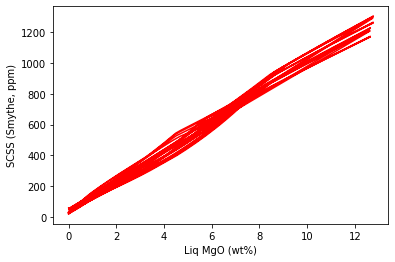

In [8]:
plt.plot(empty_index['MgO_Liq'], Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017'],'-r')
plt.xlabel('Liq MgO (wt%)')
plt.ylabel('SCSS (Smythe, ppm)')

Text(0, 0.5, 'Liq FeO (wt%)')

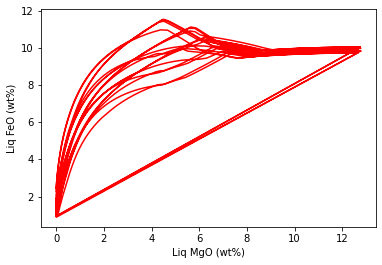

In [9]:
plt.plot(empty_index['MgO_Liq'],empty_index['FeOt_Liq'],'-r')
plt.xlabel('Liq MgO (wt%)')
plt.ylabel('Liq FeO (wt%)')

#### Using O'Neill:

In [10]:
#Fe_FeNiCu_Sulf=0.66
Fe_FeNiCu_Sulf=empty_index['Fe3Fet_Liq']
if isinstance(Fe_FeNiCu_Sulf, float) is True:
    print('float')

In [11]:
ONeill_MeasSulf=ss.calculate_O2021_SCSS(df=empty_index, T_K=empty_index['T_C']+273.15, 
P_kbar=empty_index['pressure_bar']/1000,Fe_FeNiCu_Sulf=0.66,Fe3Fet_Liq=empty_index['Fe3Fet_Liq'])
ONeill_MeasSulf.head()

Using inputted Fe_FeNiCu_Sulf ratio for calculations.


,SCSS2_ppm,LnS,Ln_a_FeO,Ln_a_FeS,DeltaG,LnCS2_calc,index,T_C,P_bar,h,...,Fet_Liq_cat_frac,Ca_Liq_cat_frac,Al_Liq_cat_frac,Na_Liq_cat_frac,K_Liq_cat_frac,Ti_Liq_cat_frac,P_Liq_cat_frac,Mg_Number_Liq_NoFe3,Mg_Number_Liq_Fe3,Fe2_Liq_cat_frac
0,1475.545953,7.296783,-2.344361,-0.483443,7.013816,-1.577952,0,1301.600000,2000,-1.196753e+06,...,0.077193,0.109411,0.138493,0.035146,0.011272,0.004728,0.0,0.694613,0.727788,0.065671
1,1458.130364,7.284910,-2.341953,-0.483385,7.044215,-1.617873,1,1296.586667,2000,-1.197805e+06,...,0.077214,0.110096,0.139390,0.035374,0.011345,0.004758,0.0,0.691286,0.724896,0.065618
2,1440.677747,7.272869,-2.339600,-0.483319,7.074818,-1.658230,2,1291.573333,2000,-1.191632e+06,...,0.077228,0.110791,0.140299,0.035605,0.011419,0.004789,0.0,0.687868,0.721926,0.065556
3,1423.316617,7.260745,-2.337324,-0.483246,7.105629,-1.698961,3,1286.560000,2000,-1.185425e+06,...,0.077236,0.111480,0.141202,0.035834,0.011493,0.004820,0.0,0.684427,0.718935,0.065488
4,1406.048108,7.248538,-2.335126,-0.483167,7.136649,-1.740069,4,1281.546667,2000,-1.179348e+06,...,0.077236,0.112165,0.142099,0.036062,0.011566,0.004851,0.0,0.680963,0.715924,0.065414


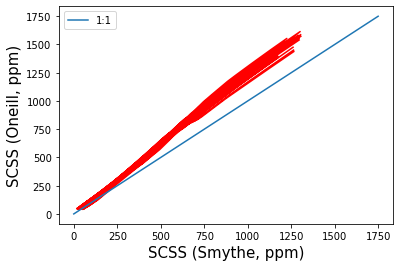

In [12]:
plt.plot(Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017'], ONeill_MeasSulf['SCSS2_ppm'],
         '-r')
plt.xlabel('SCSS (Smythe, ppm)', size=15)
plt.ylabel('SCSS (Oneill, ppm)', size=15)

plt.plot([0,1750], [0,1750], label='1:1')
plt.legend()

#### Li and Zhang 2022 - H2O sensitive, PT and fo2 sensitive.

In [13]:
LiZhang22=ss.calculate_LZ2022_SCSS(df=empty_index, T_K=empty_index['T_C']+273.15, 
P_kbar=empty_index['pressure_bar']/1000,Fe_FeNiCu_Sulf=0.66,Fe3Fet_Liq=empty_index['Fe3Fet_Liq'])
LiZhang22.head()

replacing Fe3Fet_Liq in the original dataframe with that input into the function


,SCSS_Tot,index,T_C,P_bar,h,s,v,SiO2_Liq,TiO2_Liq,Al2O3_Liq,...,Al_cat,Fe_cat,Mn_cat,Mg_cat,Ca_cat,Na_cat,K_cat,P_cat,H_cat,Fe3_cat
0,1298.301698,0,1301.600000,2000,-1.196753e+06,286.026562,37.741464,48.533599,0.680658,12.725336,...,0.138280,0.065570,0.0,0.175315,0.109242,0.035092,0.011255,0.00154,0.0,0.011504
1,1282.389714,1,1296.586667,2000,-1.197805e+06,285.357286,37.713089,48.579017,0.684571,12.798505,...,0.139174,0.065516,0.0,0.172639,0.109925,0.035319,0.011328,0.00155,0.0,0.011579
2,1266.446630,2,1291.573333,2000,-1.191632e+06,283.251871,37.506426,48.625173,0.688535,12.872603,...,0.140080,0.065454,0.0,0.169934,0.110618,0.035549,0.011401,0.00156,0.0,0.011654
3,1250.614626,3,1286.560000,2000,-1.185425e+06,281.149264,37.299633,48.671143,0.692468,12.946148,...,0.140980,0.065385,0.0,0.167254,0.111305,0.035778,0.011475,0.00157,0.0,0.011729
4,1234.894296,4,1281.546667,2000,-1.179348e+06,279.081702,37.096726,48.716926,0.696373,13.019139,...,0.141875,0.065311,0.0,0.164600,0.111987,0.036005,0.011548,0.00158,0.0,0.011803


In [14]:
empty_index.unique

0             P_2000.0_H2O_1.0_buff_QFM
1             P_2000.0_H2O_1.0_buff_QFM
2             P_2000.0_H2O_1.0_buff_QFM
3             P_2000.0_H2O_1.0_buff_QFM
4             P_2000.0_H2O_1.0_buff_QFM
                     ...               
1938    P_500.0_H2O_2.0_buff_unbuffered
1939    P_500.0_H2O_2.0_buff_unbuffered
1940    P_500.0_H2O_2.0_buff_unbuffered
1941    P_500.0_H2O_2.0_buff_unbuffered
1942    P_500.0_H2O_2.0_buff_unbuffered
Name: unique, Length: 1943, dtype: object

### Part 7: Calculating Phase Proportions

In [15]:
empty_index

,index,T_C,P_bar,h,s,v,SiO2_Liq,TiO2_Liq,Al2O3_Liq,Cr2O3_Liq,...,H2O_tridymite1,CO2_tridymite1,Fe3Fet_tridymite1,h_tridymite1,mass_tridymite1,v_tridymite1,rho_tridymite1,newentry,newcolumn,unique
0,0,1301.600000,2000,-1.196753e+06,286.026562,37.741464,48.533599,0.680658,12.725336,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_1.0_buff_QFM,P_2000.0_H2O_1.0_buff_QFM
1,1,1296.586667,2000,-1.197805e+06,285.357286,37.713089,48.579017,0.684571,12.798505,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_1.0_buff_QFM,P_2000.0_H2O_1.0_buff_QFM
2,2,1291.573333,2000,-1.191632e+06,283.251871,37.506426,48.625173,0.688535,12.872603,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_1.0_buff_QFM,P_2000.0_H2O_1.0_buff_QFM
3,3,1286.560000,2000,-1.185425e+06,281.149264,37.299633,48.671143,0.692468,12.946148,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_1.0_buff_QFM,P_2000.0_H2O_1.0_buff_QFM
4,4,1281.546667,2000,-1.179348e+06,279.081702,37.096726,48.716926,0.696373,13.019139,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_1.0_buff_QFM,P_2000.0_H2O_1.0_buff_QFM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1938,93,790.340541,500,-1.576003e+05,29.154400,5.286334,73.469503,0.150791,7.163267,0.0,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,5,H2O_2.0_buff_unbuffered,P_500.0_H2O_2.0_buff_unbuffered
1939,94,785.321622,500,-1.539317e+05,28.387238,5.158832,73.779005,0.142364,6.963491,0.0,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,5,H2O_2.0_buff_unbuffered,P_500.0_H2O_2.0_buff_unbuffered
1940,95,780.302703,500,-1.505402e+05,27.661470,5.056336,74.062892,0.134136,6.759742,0.0,...,0.0,0.0,NaN,-519.372178,0.036255,0.016569,2.188086,5,H2O_2.0_buff_unbuffered,P_500.0_H2O_2.0_buff_unbuffered
1941,96,775.283784,500,-1.463248e+05,26.752698,4.978600,74.259845,0.125202,6.511176,0.0,...,0.0,0.0,NaN,-2867.408783,0.200076,0.091437,2.188139,5,H2O_2.0_buff_unbuffered,P_500.0_H2O_2.0_buff_unbuffered


In [16]:
keepcols = empty_index.columns[empty_index.columns.str.contains('_Liq|pressure_bar|T_C|newcolumn')]
keep_ol_liq = empty_index.columns[empty_index.columns.str.contains('_Liq|pressure_bar|T_C|newcolumn|_Ol')]


In [17]:
slicedat = empty_index[keepcols]
Fo_Mg_MELTS = empty_index[keep_ol_liq]
Fo_Mg_MELTS.to_excel('Fo_Mg_MELTS.xlsx') #to be worked on in MELTS versus EPMA Olivine-melt equilibria.ipynb

In [18]:
mass_cols = empty_index.columns[empty_index.columns.str.contains('index|mass|unique')]
syst_mass = empty_index[mass_cols]
syst_mass

,index,mass_Liq,mass_Ol,mass_Cpx,mass_Plag,mass_Sp,mass_Apa,mass_Rhm,mass_rutile1,mass_Kspar,mass_fluid1,mass_biotite1,dict_index,mass_Cpx2,mass_leucite1,mass_tridymite1,unique
0,0,100.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,index = 0,NaN,NaN,NaN,P_2000.0_H2O_1.0_buff_QFM
1,1,99.428305,0.571695,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,index = 0,NaN,NaN,NaN,P_2000.0_H2O_1.0_buff_QFM
2,2,98.855966,0.573818,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,index = 0,NaN,NaN,NaN,P_2000.0_H2O_1.0_buff_QFM
3,3,98.294382,0.563064,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,index = 0,NaN,NaN,NaN,P_2000.0_H2O_1.0_buff_QFM
4,4,97.743300,0.552562,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,index = 0,NaN,NaN,NaN,P_2000.0_H2O_1.0_buff_QFM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1938,93,11.495561,0.002449,0.041078,0.0,0.0,0.009787,NaN,0.002071,0.238762,0.006920,NaN,index = 5,NaN,NaN,0.000000,P_500.0_H2O_2.0_buff_unbuffered
1939,94,11.228430,0.001420,0.040781,0.0,0.0,0.009250,NaN,0.001956,0.220530,0.006421,NaN,index = 5,NaN,NaN,0.000000,P_500.0_H2O_2.0_buff_unbuffered
1940,95,10.898076,0.000000,0.046052,0.0,0.0,0.010625,NaN,0.001961,0.239969,0.008120,NaN,index = 5,NaN,NaN,0.036255,P_500.0_H2O_2.0_buff_unbuffered
1941,96,10.227717,0.000000,0.069210,0.0,0.0,0.018427,NaN,0.002305,0.375096,0.017060,NaN,index = 5,NaN,NaN,0.200076,P_500.0_H2O_2.0_buff_unbuffered


In [19]:
column_to_move = syst_mass.pop("unique")
syst_mass.insert(16, "unique", column_to_move)
syst_mass

,index,mass_Liq,mass_Ol,mass_Cpx,mass_Plag,mass_Sp,mass_Apa,mass_Rhm,mass_rutile1,mass_Kspar,mass_fluid1,mass_biotite1,dict_index,mass_Cpx2,mass_leucite1,mass_tridymite1,unique
0,0,100.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,index = 0,NaN,NaN,NaN,P_2000.0_H2O_1.0_buff_QFM
1,1,99.428305,0.571695,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,index = 0,NaN,NaN,NaN,P_2000.0_H2O_1.0_buff_QFM
2,2,98.855966,0.573818,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,index = 0,NaN,NaN,NaN,P_2000.0_H2O_1.0_buff_QFM
3,3,98.294382,0.563064,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,index = 0,NaN,NaN,NaN,P_2000.0_H2O_1.0_buff_QFM
4,4,97.743300,0.552562,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,index = 0,NaN,NaN,NaN,P_2000.0_H2O_1.0_buff_QFM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1938,93,11.495561,0.002449,0.041078,0.0,0.0,0.009787,NaN,0.002071,0.238762,0.006920,NaN,index = 5,NaN,NaN,0.000000,P_500.0_H2O_2.0_buff_unbuffered
1939,94,11.228430,0.001420,0.040781,0.0,0.0,0.009250,NaN,0.001956,0.220530,0.006421,NaN,index = 5,NaN,NaN,0.000000,P_500.0_H2O_2.0_buff_unbuffered
1940,95,10.898076,0.000000,0.046052,0.0,0.0,0.010625,NaN,0.001961,0.239969,0.008120,NaN,index = 5,NaN,NaN,0.036255,P_500.0_H2O_2.0_buff_unbuffered
1941,96,10.227717,0.000000,0.069210,0.0,0.0,0.018427,NaN,0.002305,0.375096,0.017060,NaN,index = 5,NaN,NaN,0.200076,P_500.0_H2O_2.0_buff_unbuffered


In [20]:
syst_mass.iloc[:,2::] #should be starting with mass_ol to the end including unique

,mass_Ol,mass_Cpx,mass_Plag,mass_Sp,mass_Apa,mass_Rhm,mass_rutile1,mass_Kspar,mass_fluid1,mass_biotite1,dict_index,mass_Cpx2,mass_leucite1,mass_tridymite1,unique
0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,index = 0,NaN,NaN,NaN,P_2000.0_H2O_1.0_buff_QFM
1,0.571695,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,index = 0,NaN,NaN,NaN,P_2000.0_H2O_1.0_buff_QFM
2,0.573818,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,index = 0,NaN,NaN,NaN,P_2000.0_H2O_1.0_buff_QFM
3,0.563064,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,index = 0,NaN,NaN,NaN,P_2000.0_H2O_1.0_buff_QFM
4,0.552562,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,index = 0,NaN,NaN,NaN,P_2000.0_H2O_1.0_buff_QFM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1938,0.002449,0.041078,0.0,0.0,0.009787,NaN,0.002071,0.238762,0.006920,NaN,index = 5,NaN,NaN,0.000000,P_500.0_H2O_2.0_buff_unbuffered
1939,0.001420,0.040781,0.0,0.0,0.009250,NaN,0.001956,0.220530,0.006421,NaN,index = 5,NaN,NaN,0.000000,P_500.0_H2O_2.0_buff_unbuffered
1940,0.000000,0.046052,0.0,0.0,0.010625,NaN,0.001961,0.239969,0.008120,NaN,index = 5,NaN,NaN,0.036255,P_500.0_H2O_2.0_buff_unbuffered
1941,0.000000,0.069210,0.0,0.0,0.018427,NaN,0.002305,0.375096,0.017060,NaN,index = 5,NaN,NaN,0.200076,P_500.0_H2O_2.0_buff_unbuffered


In [21]:
# the mass crystallising at each step. 
cumulate_phase_mass = syst_mass.iloc[:,2::].sum(axis=1)
cumulate_phase_mass

0       0.000000
1       0.571695
2       0.573818
3       0.563064
4       0.552562
          ...   
1938    0.301067
1939    0.280357
1940    0.342981
1941    0.682175
1942    0.000000
Length: 1943, dtype: float64

In [22]:
# Replace all naN entries with 0 - perhaps do this in an earlier step
syst_mass = syst_mass.fillna(0)

In [23]:
 syst_mass.to_excel('practice_systmass_1.2_jan.xlsx')

In [24]:
syst_mass.columns[2:17] # we want column range starting with first phase to the end e.g. mass_Ol

Index(['mass_Ol', 'mass_Cpx', 'mass_Plag', 'mass_Sp', 'mass_Apa', 'mass_Rhm',
       'mass_rutile1', 'mass_Kspar', 'mass_fluid1', 'mass_biotite1',
       'dict_index', 'mass_Cpx2', 'mass_leucite1', 'mass_tridymite1',
       'unique'],
      dtype='object')

In [25]:
# Calculate cumulative masses of solid phases, exlcuding index column 
for i in syst_mass.columns[2:17]:
    syst_mass[i + '_cumulative'] = syst_mass.groupby('unique')[i].transform(pd.Series.cumsum)

syst_mass[syst_mass.columns[17:]]

,mass_Ol_cumulative,mass_Cpx_cumulative,mass_Plag_cumulative,mass_Sp_cumulative,mass_Apa_cumulative,mass_Rhm_cumulative,mass_rutile1_cumulative,mass_Kspar_cumulative,mass_fluid1_cumulative,mass_biotite1_cumulative,dict_index_cumulative,mass_Cpx2_cumulative,mass_leucite1_cumulative,mass_tridymite1_cumulative,unique_cumulative
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,index = 0,0.0,0.0,0.000000,P_2000.0_H2O_1.0_buff_QFM
1,0.571695,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,index = 0index = 0,0.0,0.0,0.000000,P_2000.0_H2O_1.0_buff_QFMP_2000.0_H2O_1.0_buff...
2,1.145513,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,index = 0index = 0index = 0,0.0,0.0,0.000000,P_2000.0_H2O_1.0_buff_QFMP_2000.0_H2O_1.0_buff...
3,1.708577,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,index = 0index = 0index = 0index = 0,0.0,0.0,0.000000,P_2000.0_H2O_1.0_buff_QFMP_2000.0_H2O_1.0_buff...
4,2.261139,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,index = 0index = 0index = 0index = 0index = 0,0.0,0.0,0.000000,P_2000.0_H2O_1.0_buff_QFMP_2000.0_H2O_1.0_buff...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1938,20.651403,29.753264,30.123686,4.027631,0.432931,0.0,0.060031,2.626267,1.615379,0.0,index = 5index = 5index = 5index = 5index = 5i...,0.0,0.0,0.000000,P_500.0_H2O_2.0_buff_unbufferedP_500.0_H2O_2.0...
1939,20.652823,29.794045,30.123686,4.027631,0.442181,0.0,0.061987,2.846797,1.621799,0.0,index = 5index = 5index = 5index = 5index = 5i...,0.0,0.0,0.000000,P_500.0_H2O_2.0_buff_unbufferedP_500.0_H2O_2.0...
1940,20.652823,29.840097,30.123686,4.027631,0.452806,0.0,0.063947,3.086766,1.629919,0.0,index = 5index = 5index = 5index = 5index = 5i...,0.0,0.0,0.036255,P_500.0_H2O_2.0_buff_unbufferedP_500.0_H2O_2.0...
1941,20.652823,29.909307,30.123686,4.027631,0.471233,0.0,0.066252,3.461861,1.646980,0.0,index = 5index = 5index = 5index = 5index = 5i...,0.0,0.0,0.236331,P_500.0_H2O_2.0_buff_unbufferedP_500.0_H2O_2.0...


#### Normalise cumulative phase system mass to 100

In [26]:
syst_mass[syst_mass.columns[17:32]] #select just the columns with mass_'phase'_cumulative, no Liq or unique



,mass_Ol_cumulative,mass_Cpx_cumulative,mass_Plag_cumulative,mass_Sp_cumulative,mass_Apa_cumulative,mass_Rhm_cumulative,mass_rutile1_cumulative,mass_Kspar_cumulative,mass_fluid1_cumulative,mass_biotite1_cumulative,dict_index_cumulative,mass_Cpx2_cumulative,mass_leucite1_cumulative,mass_tridymite1_cumulative,unique_cumulative
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,index = 0,0.0,0.0,0.000000,P_2000.0_H2O_1.0_buff_QFM
1,0.571695,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,index = 0index = 0,0.0,0.0,0.000000,P_2000.0_H2O_1.0_buff_QFMP_2000.0_H2O_1.0_buff...
2,1.145513,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,index = 0index = 0index = 0,0.0,0.0,0.000000,P_2000.0_H2O_1.0_buff_QFMP_2000.0_H2O_1.0_buff...
3,1.708577,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,index = 0index = 0index = 0index = 0,0.0,0.0,0.000000,P_2000.0_H2O_1.0_buff_QFMP_2000.0_H2O_1.0_buff...
4,2.261139,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,index = 0index = 0index = 0index = 0index = 0,0.0,0.0,0.000000,P_2000.0_H2O_1.0_buff_QFMP_2000.0_H2O_1.0_buff...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1938,20.651403,29.753264,30.123686,4.027631,0.432931,0.0,0.060031,2.626267,1.615379,0.0,index = 5index = 5index = 5index = 5index = 5i...,0.0,0.0,0.000000,P_500.0_H2O_2.0_buff_unbufferedP_500.0_H2O_2.0...
1939,20.652823,29.794045,30.123686,4.027631,0.442181,0.0,0.061987,2.846797,1.621799,0.0,index = 5index = 5index = 5index = 5index = 5i...,0.0,0.0,0.000000,P_500.0_H2O_2.0_buff_unbufferedP_500.0_H2O_2.0...
1940,20.652823,29.840097,30.123686,4.027631,0.452806,0.0,0.063947,3.086766,1.629919,0.0,index = 5index = 5index = 5index = 5index = 5i...,0.0,0.0,0.036255,P_500.0_H2O_2.0_buff_unbufferedP_500.0_H2O_2.0...
1941,20.652823,29.909307,30.123686,4.027631,0.471233,0.0,0.066252,3.461861,1.646980,0.0,index = 5index = 5index = 5index = 5index = 5i...,0.0,0.0,0.236331,P_500.0_H2O_2.0_buff_unbufferedP_500.0_H2O_2.0...


In [27]:
syst_mass['mass_allphase_cumulative'] = syst_mass[syst_mass.columns[17:32]].sum(axis=1)

syst_mass['mass_syst_unormtot'] = syst_mass['mass_allphase_cumulative'] + syst_mass['mass_Liq']

In [28]:
syst_mass[['mass_allphase_cumulative','mass_syst_unormtot']]

,mass_allphase_cumulative,mass_syst_unormtot
0,0.000000,100.000000
1,0.571695,100.000000
2,1.145513,100.001479
3,1.708577,100.002958
4,2.261139,100.004439
...,...,...
1938,89.290591,100.786153
1939,89.570949,100.799378
1940,89.913930,100.812006
1941,90.596104,100.823822


In [29]:
syst_mass.columns[17:]

Index(['mass_Ol_cumulative', 'mass_Cpx_cumulative', 'mass_Plag_cumulative',
       'mass_Sp_cumulative', 'mass_Apa_cumulative', 'mass_Rhm_cumulative',
       'mass_rutile1_cumulative', 'mass_Kspar_cumulative',
       'mass_fluid1_cumulative', 'mass_biotite1_cumulative',
       'dict_index_cumulative', 'mass_Cpx2_cumulative',
       'mass_leucite1_cumulative', 'mass_tridymite1_cumulative',
       'unique_cumulative', 'mass_allphase_cumulative', 'mass_syst_unormtot'],
      dtype='object')

In [30]:
# move column containing strings to the first column
# col = syst_mass.pop('unique_cumulative')
# syst_mass.insert(0, 'unique_cumulative', col)

# move column mass_Liq next to the cumualtive columns - position may change based on number of phases 
col = syst_mass.pop('mass_Liq')
syst_mass.insert(16, 'mass_Liq', col)

# drop mass_Liq_cumulative column since it is meaningless if havent done already
#syst_mass = syst_mass.drop(['mass_Liq_cumulative'], axis=1)
#drop index and unique cumulative
syst_mass = syst_mass.drop(['unique_cumulative', 'dict_index_cumulative'], axis=1)


In [31]:
syst_mass.columns[14:]
syst_mass[syst_mass.columns[17:30]].tail()

,mass_Ol_cumulative,mass_Cpx_cumulative,mass_Plag_cumulative,mass_Sp_cumulative,mass_Apa_cumulative,mass_Rhm_cumulative,mass_rutile1_cumulative,mass_Kspar_cumulative,mass_fluid1_cumulative,mass_biotite1_cumulative,mass_Cpx2_cumulative,mass_leucite1_cumulative,mass_tridymite1_cumulative
1938,20.651403,29.753264,30.123686,4.027631,0.432931,0.0,0.060031,2.626267,1.615379,0.0,0.0,0.0,0.000000
1939,20.652823,29.794045,30.123686,4.027631,0.442181,0.0,0.061987,2.846797,1.621799,0.0,0.0,0.0,0.000000
1940,20.652823,29.840097,30.123686,4.027631,0.452806,0.0,0.063947,3.086766,1.629919,0.0,0.0,0.0,0.036255
1941,20.652823,29.909307,30.123686,4.027631,0.471233,0.0,0.066252,3.461861,1.646980,0.0,0.0,0.0,0.236331
1942,20.652823,29.909307,30.123686,4.027631,0.471233,0.0,0.066252,3.461861,1.646980,0.0,0.0,0.0,0.236331


In [32]:
syst_mass[syst_mass.columns[16:32]].tail() #mass_liq and all _cumulative phases mass_allphase_cumu and mass_syst_unormtot

,mass_Liq,mass_Ol_cumulative,mass_Cpx_cumulative,mass_Plag_cumulative,mass_Sp_cumulative,mass_Apa_cumulative,mass_Rhm_cumulative,mass_rutile1_cumulative,mass_Kspar_cumulative,mass_fluid1_cumulative,mass_biotite1_cumulative,mass_Cpx2_cumulative,mass_leucite1_cumulative,mass_tridymite1_cumulative,mass_allphase_cumulative,mass_syst_unormtot
1938,11.495561,20.651403,29.753264,30.123686,4.027631,0.432931,0.0,0.060031,2.626267,1.615379,0.0,0.0,0.0,0.000000,89.290591,100.786153
1939,11.228430,20.652823,29.794045,30.123686,4.027631,0.442181,0.0,0.061987,2.846797,1.621799,0.0,0.0,0.0,0.000000,89.570949,100.799378
1940,10.898076,20.652823,29.840097,30.123686,4.027631,0.452806,0.0,0.063947,3.086766,1.629919,0.0,0.0,0.0,0.036255,89.913930,100.812006
1941,10.227717,20.652823,29.909307,30.123686,4.027631,0.471233,0.0,0.066252,3.461861,1.646980,0.0,0.0,0.0,0.236331,90.596104,100.823822
1942,0.000000,20.652823,29.909307,30.123686,4.027631,0.471233,0.0,0.066252,3.461861,1.646980,0.0,0.0,0.0,0.236331,90.596104,90.596104


In [33]:
#from liq_mass to final mass_'phase'_cumulative
for i in syst_mass.columns[16:30]:
    syst_mass[i + '_NORM'] = (syst_mass[i] * 100) / (syst_mass['mass_syst_unormtot'])
syst_mass.columns[30:]

Index(['mass_allphase_cumulative', 'mass_syst_unormtot', 'mass_Liq_NORM',
       'mass_Ol_cumulative_NORM', 'mass_Cpx_cumulative_NORM',
       'mass_Plag_cumulative_NORM', 'mass_Sp_cumulative_NORM',
       'mass_Apa_cumulative_NORM', 'mass_Rhm_cumulative_NORM',
       'mass_rutile1_cumulative_NORM', 'mass_Kspar_cumulative_NORM',
       'mass_fluid1_cumulative_NORM', 'mass_biotite1_cumulative_NORM',
       'mass_Cpx2_cumulative_NORM', 'mass_leucite1_cumulative_NORM',
       'mass_tridymite1_cumulative_NORM'],
      dtype='object')

In [34]:
syst_mass[syst_mass.columns[32:]].tail()

,mass_Liq_NORM,mass_Ol_cumulative_NORM,mass_Cpx_cumulative_NORM,mass_Plag_cumulative_NORM,mass_Sp_cumulative_NORM,mass_Apa_cumulative_NORM,mass_Rhm_cumulative_NORM,mass_rutile1_cumulative_NORM,mass_Kspar_cumulative_NORM,mass_fluid1_cumulative_NORM,mass_biotite1_cumulative_NORM,mass_Cpx2_cumulative_NORM,mass_leucite1_cumulative_NORM,mass_tridymite1_cumulative_NORM
1938,11.405894,20.490318,29.521182,29.888715,3.996215,0.429554,0.0,0.059563,2.605782,1.602778,0.0,0.0,0.0,0.000000
1939,11.139384,20.489038,29.557767,29.884794,3.995691,0.438674,0.0,0.061495,2.824221,1.608938,0.0,0.0,0.0,0.000000
1940,10.810296,20.486471,29.599745,29.881050,3.995190,0.449159,0.0,0.063432,3.061903,1.616791,0.0,0.0,0.0,0.035963
1941,10.144148,20.484070,29.664921,29.877548,3.994722,0.467383,0.0,0.065711,3.433575,1.633522,0.0,0.0,0.0,0.234400
1942,0.000000,22.796590,33.013900,33.250531,4.445700,0.520147,0.0,0.073129,3.821203,1.817936,0.0,0.0,0.0,0.260862


In [35]:
syst_mass[syst_mass.columns[32:]].sum(axis=1) #check all liq and phases norm sum to 100

0       100.0
1       100.0
2       100.0
3       100.0
4       100.0
        ...  
1938    100.0
1939    100.0
1940    100.0
1941    100.0
1942    100.0
Length: 1943, dtype: float64

In [36]:
syst_mass.columns[32:]

Index(['mass_Liq_NORM', 'mass_Ol_cumulative_NORM', 'mass_Cpx_cumulative_NORM',
       'mass_Plag_cumulative_NORM', 'mass_Sp_cumulative_NORM',
       'mass_Apa_cumulative_NORM', 'mass_Rhm_cumulative_NORM',
       'mass_rutile1_cumulative_NORM', 'mass_Kspar_cumulative_NORM',
       'mass_fluid1_cumulative_NORM', 'mass_biotite1_cumulative_NORM',
       'mass_Cpx2_cumulative_NORM', 'mass_leucite1_cumulative_NORM',
       'mass_tridymite1_cumulative_NORM'],
      dtype='object')

In [37]:
# seperate calc for mass_allphase_NORMcumulative i.e. excluding the liq_cumunorm mass
# careful rerunning cell as will give false result
syst_mass['mass_allphase_NORMcumu'] = syst_mass[syst_mass.columns[33:]].sum(axis=1)
syst_mass['mass_allphase_NORMcumu']

0         0.000000
1         0.571695
2         1.145496
3         1.708526
4         2.261038
           ...    
1938     88.594106
1939     88.860616
1940     89.189704
1941     89.855852
1942    100.000000
Name: mass_allphase_NORMcumu, Length: 1943, dtype: float64

In [38]:
syst_mass[syst_mass.columns[33:]] #range of cumulative_norm mass phases

,mass_Ol_cumulative_NORM,mass_Cpx_cumulative_NORM,mass_Plag_cumulative_NORM,mass_Sp_cumulative_NORM,mass_Apa_cumulative_NORM,mass_Rhm_cumulative_NORM,mass_rutile1_cumulative_NORM,mass_Kspar_cumulative_NORM,mass_fluid1_cumulative_NORM,mass_biotite1_cumulative_NORM,mass_Cpx2_cumulative_NORM,mass_leucite1_cumulative_NORM,mass_tridymite1_cumulative_NORM,mass_allphase_NORMcumu
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
1,0.571695,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.571695
2,1.145496,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.145496
3,1.708526,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.708526
4,2.261038,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,2.261038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1938,20.490318,29.521182,29.888715,3.996215,0.429554,0.0,0.059563,2.605782,1.602778,0.0,0.0,0.0,0.000000,88.594106
1939,20.489038,29.557767,29.884794,3.995691,0.438674,0.0,0.061495,2.824221,1.608938,0.0,0.0,0.0,0.000000,88.860616
1940,20.486471,29.599745,29.881050,3.995190,0.449159,0.0,0.063432,3.061903,1.616791,0.0,0.0,0.0,0.035963,89.189704
1941,20.484070,29.664921,29.877548,3.994722,0.467383,0.0,0.065711,3.433575,1.633522,0.0,0.0,0.0,0.234400,89.855852


In [39]:
# where ppn 1 refers to proportion of phases (solid + fluid1) excluding sulfide
# need columns from first and last phase_cumulative_norm masses - test search using cell above
for i in syst_mass.columns[33:]:
    syst_mass[i + '_ppn1'] = (syst_mass[i]) / (syst_mass['mass_allphase_NORMcumu'])


In [40]:
syst_mass[syst_mass.columns[47:]].tail()
# mass_allphase_Normcumu_ppn1 1 should all be = 1 if calc correct

,mass_Ol_cumulative_NORM_ppn1,mass_Cpx_cumulative_NORM_ppn1,mass_Plag_cumulative_NORM_ppn1,mass_Sp_cumulative_NORM_ppn1,mass_Apa_cumulative_NORM_ppn1,mass_Rhm_cumulative_NORM_ppn1,mass_rutile1_cumulative_NORM_ppn1,mass_Kspar_cumulative_NORM_ppn1,mass_fluid1_cumulative_NORM_ppn1,mass_biotite1_cumulative_NORM_ppn1,mass_Cpx2_cumulative_NORM_ppn1,mass_leucite1_cumulative_NORM_ppn1,mass_tridymite1_cumulative_NORM_ppn1,mass_allphase_NORMcumu_ppn1
1938,0.231283,0.333218,0.337367,0.045107,0.004849,0.0,0.000672,0.029413,0.018091,0.0,0.0,0.0,0.000000,1.0
1939,0.230575,0.332631,0.336311,0.044966,0.004937,0.0,0.000692,0.031783,0.018106,0.0,0.0,0.0,0.000000,1.0
1940,0.229695,0.331874,0.335028,0.044794,0.005036,0.0,0.000711,0.034330,0.018128,0.0,0.0,0.0,0.000403,1.0
1941,0.227966,0.330139,0.332505,0.044457,0.005201,0.0,0.000731,0.038212,0.018179,0.0,0.0,0.0,0.002609,1.0
1942,0.227966,0.330139,0.332505,0.044457,0.005201,0.0,0.000731,0.038212,0.018179,0.0,0.0,0.0,0.002609,1.0


#### Modelling sulfur

In [41]:
syst_mass.unique.unique() #note that order of pressure - this is the order that the dictioanry msut be read in as. 
#fix this bug later. 

array(['P_2000.0_H2O_1.0_buff_QFM', 'P_2000.0_H2O_2.0_buff_QFM',
       'P_2000.0_H2O_2.0_buff_QFM_1', 'P_2000.0_H2O_1.0_buff_QFM_1',
       'P_2000.0_H2O_2.0_buff_unbuffered',
       'P_2000.0_H2O_1.0_buff_unbuffered', 'P_1000.0_H2O_2.0_buff_QFM',
       'P_1000.0_H2O_1.0_buff_QFM', 'P_1000.0_H2O_1.0_buff_QFM_1',
       'P_1000.0_H2O_2.0_buff_QFM_1', 'P_1000.0_H2O_1.0_buff_unbuffered',
       'P_1000.0_H2O_2.0_buff_unbuffered', 'P_500.0_H2O_2.0_buff_QFM_1',
       'P_500.0_H2O_2.0_buff_QFM', 'P_500.0_H2O_1.0_buff_QFM',
       'P_500.0_H2O_1.0_buff_QFM_1', 'P_500.0_H2O_1.0_buff_unbuffered',
       'P_500.0_H2O_2.0_buff_unbuffered'], dtype=object)

In [42]:
#append SCSS to working dataframe syst_mass
syst_mass['SCSS_LiZhang22']= LiZhang22['SCSS_Tot']
syst_mass['SCSS_Smythe17']= Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017']
syst_mass['SCSS_Oneill21']= ONeill_MeasSulf['SCSS2_ppm']

In [43]:
syst_mass['melt_f'] = (syst_mass.mass_Liq_NORM) / 100
# replace nan with 0
syst_mass = syst_mass.replace(np.nan, 0)
syst_mass['mass_fluid1_cumulative_NORM_ppn1']

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
1938    0.018091
1939    0.018106
1940    0.018128
1941    0.018179
1942    0.018179
Name: mass_fluid1_cumulative_NORM_ppn1, Length: 1943, dtype: float64

In [44]:
DS = np.empty(len(syst_mass), dtype=float)

# Calculate cocnentrations in bulk system i.e. completely incompatible behaviour of S
S_initial = 1000 #(ppm) assumed input, this can be changed or iterated in a loop 

In [45]:
# not yet got an fo2 sensitive DS fluid-melt

DS_4000 = {1:3, 0.9:3, 0.8:3, 0.7:5, 0.6:8, 0.5:30, 0.4:50, 0.3:100, 0.2:200, 0.1:300, 0.0:300}

DS_2000 = {1:2, 0.9:2, 0.8:2, 0.7:5, 0.6:8, 0.5:30, 0.4:50, 0.3:100, 0.2:200, 0.1:300, 0.0:300}

DS_1600 = {1:1.1, 0.9:1.1, 0.8:1.1, 0.7:5, 0.6:8, 0.5:30, 0.4:50, 0.3:100, 0.2:200, 0.1:300, 0.0:300}

DS_800 = {1:8, 0.9:8, 0.8:8, 0.7:8, 0.6:8, 0.5:30, 0.4:50, 0.3:100, 0.2:200, 0.1:300, 0.0:300}

#DS_dict = {'2000':DS_2000,'4000':DS_4000 ,'500':DS_800,'1000':DS_1600,  }
DS_dict = {'2000':DS_2000,'1000':DS_1600,'500':DS_800 }

In [46]:
###### define truncate function
import math
def truncate(number, decimals=1):
    """
    Returns a value truncated to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer.")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more.")
    elif decimals == 0:
        return math.trunc(number)

    factor = 10.0 ** decimals
    return math.trunc(number * factor) / factor

In [47]:
# create extra column for melt fraction truncated to 1 dp
syst_mass['meltf_1dp1'] = 0 
meltf_1dp = []

for i in range(len(syst_mass)):
    x = syst_mass['melt_f'][i]
    syst_mass['meltf_1dp1'] = truncate(x, decimals=1)
    meltf_1dp.append(syst_mass['meltf_1dp1'].loc[i])
syst_mass['meltf_1dp1'] = meltf_1dp

In [48]:
empty = []
for key, val in DS_dict.items():
    print(key,val)
    dfnew = syst_mass[syst_mass.unique.str.contains(key)]
    
    dfnew['Dsulfur'] = dfnew['meltf_1dp1'].map(val)
    
    print(dfnew[['unique','melt_f','meltf_1dp1', 'Dsulfur']])
    
    empty.append(dfnew['Dsulfur'])
    
    flat_list = [item for sublist in empty for item in sublist]
    
    syst_mass['DS_fm'] = pd.Series(flat_list)

2000 {1: 2, 0.9: 2, 0.8: 2, 0.7: 5, 0.6: 8, 0.5: 30, 0.4: 50, 0.3: 100, 0.2: 200, 0.1: 300, 0.0: 300}
                               unique    melt_f  meltf_1dp1  Dsulfur
0           P_2000.0_H2O_1.0_buff_QFM  1.000000         1.0        2
1           P_2000.0_H2O_1.0_buff_QFM  0.994283         0.9        2
2           P_2000.0_H2O_1.0_buff_QFM  0.988545         0.9        2
3           P_2000.0_H2O_1.0_buff_QFM  0.982915         0.9        2
4           P_2000.0_H2O_1.0_buff_QFM  0.977390         0.9        2
..                                ...       ...         ...      ...
700  P_2000.0_H2O_1.0_buff_unbuffered  0.112963         0.1      300
701  P_2000.0_H2O_1.0_buff_unbuffered  0.109593         0.1      300
702  P_2000.0_H2O_1.0_buff_unbuffered  0.106473         0.1      300
703  P_2000.0_H2O_1.0_buff_unbuffered  0.103645         0.1      300
704  P_2000.0_H2O_1.0_buff_unbuffered  0.000000         0.0      300

[705 rows x 4 columns]
1000 {1: 1.1, 0.9: 1.1, 0.8: 1.1, 0.7: 5, 0.6:

<ipython-input-48-968d0480f146>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfnew['Dsulfur'] = dfnew['meltf_1dp1'].map(val)
<ipython-input-48-968d0480f146>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfnew['Dsulfur'] = dfnew['meltf_1dp1'].map(val)
<ipython-input-48-968d0480f146>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [49]:
# check ordering of DS with melt frac - really important - ordered dictionary issue
syst_mass[['DS_fm','meltf_1dp1', 'melt_f', 'unique']].to_excel('flatlist1.2.xlsx') #check htat the DS matches up, issues with dict orders
empty[2].to_excel('clempty1.2.xlsx')

In [50]:
# Calc Bulk fluid-melt partition coeffcient of S
syst_mass['bulk_DS'] = syst_mass['DS_fm'] * syst_mass['mass_fluid1_cumulative_NORM_ppn1']

syst_mass['bulk_S_syst'] = S_initial / syst_mass['melt_f']

# Calc Melt S ppm concentration (sulfide absent FC)
syst_mass['melt_S_nosulf'] = S_initial/ ((syst_mass['bulk_DS']*(1-syst_mass['melt_f'])+ syst_mass['melt_f']))

# Make new column filled with 1000 so we know if calcs have worked or not - ammend this later as not tidy
syst_mass['melt_S_sulf'] = 1000.0000
syst_mass['melt_S_sulf']  

0       1000.0
1       1000.0
2       1000.0
3       1000.0
4       1000.0
         ...  
1938    1000.0
1939    1000.0
1940    1000.0
1941    1000.0
1942    1000.0
Name: melt_S_sulf, Length: 1943, dtype: float64

In [51]:
 syst_mass.to_excel('sulfurcehck_jan.xlsx')

In [52]:
# Calc Melt S ppm conc (sulfide present FC)
to_fill = []
u_list = syst_mass.unique.unique()
for u in u_list:
    df = syst_mass[syst_mass.unique == u]
    df = df.reset_index(drop=True)
    
    for i in range(0, len(df)):
        if i == 0:
            df['melt_S_sulf'] =1000.0000
            to_fill.append(df['melt_S_sulf'].loc[i])
    
    for i in range(1, len(df)):
        if df['melt_S_sulf'].loc[i-1] < df['SCSS_Oneill21'].loc[i]:
            df['melt_S_sulf'].loc[i] =  S_initial / ((df['bulk_DS'].loc[i]*(1-df['melt_f'].loc[i])+ df['melt_f'].loc[i]))
            to_fill.append(df['melt_S_sulf'].loc[i])
            
        if df.melt_S_sulf.loc[i-1] >= df['SCSS_Oneill21'].loc[i]:
            df.melt_S_sulf.loc[i] = df['SCSS_Oneill21'].loc[i] 
            to_fill.append(df['melt_S_sulf'].loc[i])
        
        #print(i,df['melt_S_sulf'].loc[i]) #prints each loop from index 1 to the end 
print(len(to_fill))

syst_mass['melt_S_sulf'] = to_fill

/Users/ollie/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


1943


In [53]:
syst_mass['melt_S_sulf'].iloc[225:237]

225      42.645633
226      42.062020
227      41.461700
228      41.101202
229      40.977304
230      40.763342
231      40.612309
232     348.718594
233      41.166790
234     334.402092
235      42.311782
236    1000.000000
Name: melt_S_sulf, dtype: float64

#old method 
for i in range(1,len(syst_mass)):
    if syst_mass.melt_S_sulf.loc[i-1] < syst_mass['SCSS_Oneill21'].loc[i]:
       syst_mass.melt_S_sulf.loc[i] =  S_initial / ((syst_mass['bulk_DS'].loc[i]*(1-syst_mass['melt_f'].loc[i])+ syst_mass['melt_f'].loc[i]))
    elif syst_mass.melt_S_sulf.loc[i-1] >= syst_mass['SCSS_Oneill21'].loc[i]:
        syst_mass.melt_S_sulf.loc[i] = syst_mass['SCSS_Oneill21'].loc[i] 
syst_mass

In [54]:
syst_mass['fluid_S'] = syst_mass['bulk_S_syst'] - syst_mass['melt_S_nosulf']
syst_mass.fluid_S

0          0.000000
1          0.000000
2          0.000000
3          0.000000
4          0.000000
           ...     
1938    8564.244119
1939    8774.654629
1940    9048.765654
1941    9657.980970
1942            inf
Name: fluid_S, Length: 1943, dtype: float64

In [55]:
syst_mass['solid_S'] = 0
syst_mass['solid_S']

0       0
1       0
2       0
3       0
4       0
       ..
1938    0
1939    0
1940    0
1941    0
1942    0
Name: solid_S, Length: 1943, dtype: int64

#### Calculate solid S - method 1

syst_mass.solid_S = ((syst_mass.melt_S_nosulf - syst_mass.melt_S_sulf)/syst_mass.melt_S_nosulf) * syst_mass.melt_S_nosulf
syst_mass.solid_S.loc[0] = 0
syst_mass.loc[199:] 

In [56]:
u_list = syst_mass.unique.unique()
for u in u_list:
    df = syst_mass[syst_mass.unique == u]
    df = df.reset_index(drop=True)
    
    for i in range(len(df)):
        if df['index'][i] == 0:
            df['solid_S'].loc[i] = 0
        
        elif df['melt_S_sulf'].loc[i] < df['SCSS_Oneill21'].loc[i]:
            df.solid_S.loc[i] = df.solid_S.loc[i-1]
            ##fill.append(df.solid_S.loc[i]) 
            
        if df.melt_S_sulf.loc[i] >= df['SCSS_Oneill21'].loc[i]:
            df.solid_S.loc[i] = ((df.melt_S_nosulf.loc[i] - df.melt_S_sulf.loc[i])/df.melt_S_nosulf.loc[i]) * df.melt_S_nosulf.loc[i]
            ##fill.append(df.solid_S.loc[i])
        
           
            
        print(i,df['solid_S'].loc[i])
    


0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 7.058979075633715
23 64.15843683848584
24 130.02656481588656
25 195.15590308141998
26 259.5459156400725
27 323.1950585240604
28 386.1010142365047
29 448.26089451779154
30 509.67141589760064
31 570.329051873798
32 630.2301650583785
33 689.3711221588626
34 752.8041604095378
35 819.7191509134806
36 886.5667374041574
37 953.3668054717384
38 1020.1402904187113
39 1086.909945655715
40 1153.7011053999834
41 1220.5424729941037
42 1315.2309443082047
43 1424.7420284307627
44 1532.712754681856
45 1639.1873525946455
46 1744.238247022167
47 1847.9566513394022
48 1950.4455531990563
49 2051.8143698533486
50 2152.174776497289
51 2251.637365711732
52 2350.3089080223685
53 2448.2900693190427
54 2545.673507235448
55 2642.5423190556317
56 2738.969591832114
57 2835.019628595835
58 2930.7423203566464
59 3026.1752631792547
60 3121.3445232004196
61 3216.265409797763
62 3310.9435409633993
63 3405.376112679509

112 278.66591033894304
113 272.4308404169403
114 0.0
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0.0
23 76.66693725920663
24 147.02660612790896
25 216.460391578187
26 284.96183034844444
27 352.52437505222383
28 419.14157397694885
29 484.8072230061741
30 549.5154931035383
31 613.2610360905035
32 695.2914031017442
33 799.7084751984415
34 903.7853470763079
35 1007.5568281135469
36 1110.5328273046766
37 1212.4474171266643
38 1313.1562083893625
39 1412.5904781601428
40 1510.7319880434375
41 1607.5973398490582
42 1703.2274847204094
43 1797.6803387118182
44 1891.025413766678
45 1983.3398189232278
46 2074.7052214914042
47 2165.2054923876603
48 2254.924846556245
49 2343.9463452296195
50 2432.3506674283135
51 2520.2150861169694
52 2607.612605389987
53 2694.611229664237
54 2781.2739582818767
55 2867.6607679637295
56 2953.8226639058776
57 3039.803317298035
58 3125.6393568403205
59 3211.3602705663757
60 3296.9884258482152
61 3382.5392116791

27 136.46313962034196
28 202.87275328997737
29 270.05011480593487
30 375.4442621318161
31 474.122761843806
32 566.7555092403273
33 653.934666548113
34 736.1835113682188
35 813.96490883839
36 887.6893742249383
37 958.8479219285942
38 1038.0509305674655
39 1116.3577780674548
40 1193.7418197944287
41 1270.1935594667723
42 1345.7156724599479
43 1387.3526056121696
44 1421.533891988138
45 1322.9124020468118
46 1316.783783043243
47 1312.2402600450814
48 1308.8611042455698
49 1306.3319084654472
50 875.2588537269461
51 855.2056821460068
52 838.2517344363987
53 823.7541605462786
54 811.2237684952595
55 800.2838862741512
56 790.641469225849
57 782.0664235052683
58 774.3765678780888
59 374.05173542725265
60 370.27834553539293
61 367.0302951287679
62 364.21081330214287
63 361.74187026282175
64 359.5602414140534
65 357.61453738205734
66 355.86292561649054
67 354.2713508497081
68 352.8804263554535
69 351.6680333393384
70 350.53466182190857
71 349.46661909056854
72 348.4530993307379
73 347.48560683986

27 213.76798237028015
28 282.56753136129646
29 350.36125592981585
30 417.14584847577976
31 485.0025925709734
32 553.2822312443373
33 628.2415993757148
34 750.0303588838661
35 869.15643966961
36 985.5640936706137
37 1099.2551831520236
38 1210.2753910854804
39 1318.7026864121215
40 1424.6379789902287
41 1528.1977448056768
42 1629.5083316981236
43 1728.7016420880411
44 1825.9119080833555
45 1921.27331054308
46 1964.3626432495103
47 1837.2622713349083
48 1794.25232856099
49 1757.1189904073012
50 1724.6761462605273
51 1696.0283135632885
52 1670.491078734906
53 1647.535193420241
54 1626.7457277122298
55 1029.610393672259
56 1000.546483076349
57 975.116217789349
58 952.706230696197
59 932.832303145094
60 915.1070085191075
61 899.2165362472707
62 884.9038730667219
63 871.9785233577397
64 860.4273962662701
65 849.934371436972
66 840.3411824241873
67 831.5394397747024
68 823.4371976288282
69 815.9560615848686
70 543.319627803822
71 538.7758716815028
72 534.5842598288498
73 530.7046852009389
74 5

In [57]:
# Calculate solid S - method 2
# took a while to relaise you need append after each if statement to acquire every calc
fill = []
u_list = syst_mass.unique.unique()
for u in u_list:
    df = syst_mass[syst_mass.unique == u]
    
    df = df.reset_index()
    
    for i in range(len(df)):

        if i == 0:
            df['solid_S'].loc[i] = 0.0
            fill.append(df.solid_S.loc[i])
    
        elif df['melt_S_sulf'].loc[i] < df['SCSS_Oneill21'].loc[i]:
            df.solid_S.loc[i] = df.solid_S.loc[i-1]
            fill.append(df.solid_S.loc[i])
        
        if df.melt_S_sulf.loc[i] >= df['SCSS_Oneill21'].loc[i]:
            df.solid_S.loc[i] = ((df.melt_S_nosulf.loc[i] - df.melt_S_sulf.loc[i])/df.melt_S_nosulf.loc[i]) * df.melt_S_nosulf.loc[i]
            fill.append(df.solid_S.loc[i])
        #print(i, df.solid_S.loc[i])
    #print(i, fill)

In [58]:
len(fill), len(syst_mass), [len(fill) - len(syst_mass)]

(1943, 1943, [0])

In [59]:
# Calculate solid S - method 2
# took a while to relaise you need append after each if statement to acquire every calc
fill = []
u_list = syst_mass.unique.unique()
for u in u_list:
    df = syst_mass[syst_mass.unique == u]
    df = df.reset_index()
    
    for i in range(len(df)):
        if i == 0:
            df['solid_S'].loc[i] = 0
            fill.append(df.solid_S.loc[i])
        
        elif df['melt_S_sulf'].loc[i] < df['SCSS_Oneill21'].loc[i]:
            df.solid_S.loc[i] = df.solid_S.loc[i-1]
            fill.append(df.solid_S.loc[i])
        if df.melt_S_sulf.loc[i] >= df['SCSS_Oneill21'].loc[i]:
            df.solid_S.loc[i] = ((df.melt_S_nosulf.loc[i] - df.melt_S_sulf.loc[i])/df.melt_S_nosulf.loc[i]) * df.melt_S_nosulf.loc[i]

            fill.append(df.solid_S.loc[i])
print((fill))

# replace solid_s column with fill values 

syst_mass['solid_S'] = fill

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7.058979075633715, 64.15843683848584, 130.02656481588656, 195.15590308141998, 259.5459156400725, 323.1950585240604, 386.1010142365047, 448.26089451779154, 509.67141589760064, 570.329051873798, 630.2301650583785, 689.3711221588626, 752.8041604095378, 819.7191509134806, 886.5667374041574, 953.3668054717384, 1020.1402904187113, 1086.909945655715, 1153.7011053999834, 1220.5424729941037, 1315.2309443082047, 1424.7420284307627, 1532.712754681856, 1639.1873525946455, 1744.238247022167, 1847.9566513394022, 1950.4455531990563, 2051.8143698533486, 2152.174776497289, 2251.637365711732, 2350.3089080223685, 2448.2900693190427, 2545.673507235448, 2642.5423190556317, 2738.969591832114, 2835.019628595835, 2930.7423203566464, 3026.1752631792547, 3121.3445232004196, 3216.265409797763, 3310.9435409633993, 3405.376112679509, 3499.5532758071213, 3593.4595275937777, 3689.357681170738, 3785.4698746297036, 3881.1213389382738, 3976.299094207434

In [60]:
syst_mass[['unique','meltf_1dp1','DS_fm','melt_S_sulf','fluid_S','solid_S']].loc[229:] 

,unique,meltf_1dp1,DS_fm,melt_S_sulf,fluid_S,solid_S
229,P_2000.0_H2O_2.0_buff_QFM,0.1,300.0,40.977304,6428.903946,340.241185
230,P_2000.0_H2O_2.0_buff_QFM,0.1,300.0,40.763342,6687.270694,327.774434
231,P_2000.0_H2O_2.0_buff_QFM,0.1,300.0,40.612309,6935.086100,317.168758
232,P_2000.0_H2O_2.0_buff_QFM,0.1,300.0,348.718594,7169.436732,0.000000
233,P_2000.0_H2O_2.0_buff_QFM,0.1,300.0,41.166790,7390.750662,299.903845
...,...,...,...,...,...,...
1938,P_500.0_H2O_2.0_buff_unbuffered,0.1,300.0,47.181856,8564.244119,155.971309
1939,P_500.0_H2O_2.0_buff_unbuffered,0.1,300.0,46.528268,8774.654629,155.974352
1940,P_500.0_H2O_2.0_buff_unbuffered,0.1,300.0,46.071429,9048.765654,155.603485
1941,P_500.0_H2O_2.0_buff_unbuffered,0.1,300.0,199.919703,9657.980970,0.000000


#### Calculate solid proportions including sulfide 

In [61]:
# Xsulf = proportion of sulfide
Xsulf = syst_mass.solid_S / (36 * 10000)
syst_mass['Xsulf'] = Xsulf

In [62]:
syst_mass[syst_mass.columns[47:60]].tail() #columns containing mass_'phase_norm_ppn1

,mass_Ol_cumulative_NORM_ppn1,mass_Cpx_cumulative_NORM_ppn1,mass_Plag_cumulative_NORM_ppn1,mass_Sp_cumulative_NORM_ppn1,mass_Apa_cumulative_NORM_ppn1,mass_Rhm_cumulative_NORM_ppn1,mass_rutile1_cumulative_NORM_ppn1,mass_Kspar_cumulative_NORM_ppn1,mass_fluid1_cumulative_NORM_ppn1,mass_biotite1_cumulative_NORM_ppn1,mass_Cpx2_cumulative_NORM_ppn1,mass_leucite1_cumulative_NORM_ppn1,mass_tridymite1_cumulative_NORM_ppn1
1938,0.231283,0.333218,0.337367,0.045107,0.004849,0.0,0.000672,0.029413,0.018091,0.0,0.0,0.0,0.000000
1939,0.230575,0.332631,0.336311,0.044966,0.004937,0.0,0.000692,0.031783,0.018106,0.0,0.0,0.0,0.000000
1940,0.229695,0.331874,0.335028,0.044794,0.005036,0.0,0.000711,0.034330,0.018128,0.0,0.0,0.0,0.000403
1941,0.227966,0.330139,0.332505,0.044457,0.005201,0.0,0.000731,0.038212,0.018179,0.0,0.0,0.0,0.002609
1942,0.227966,0.330139,0.332505,0.044457,0.005201,0.0,0.000731,0.038212,0.018179,0.0,0.0,0.0,0.002609


In [63]:
for i in syst_mass.columns[47:60]:
    syst_mass[i + '_ppn2'] = (syst_mass[i] / (syst_mass['mass_allphase_NORMcumu_ppn1'] + syst_mass['Xsulf']))

syst_mass['Xsulf_NORM_ppn2'] = syst_mass['Xsulf']/ (syst_mass['mass_allphase_NORMcumu_ppn1'] + syst_mass['Xsulf'])
syst_mass[['mass_Ol_cumulative_NORM_ppn1','mass_Ol_cumulative_NORM_ppn1_ppn2', 'Xsulf','Xsulf_NORM_ppn2']]

,mass_Ol_cumulative_NORM_ppn1,mass_Ol_cumulative_NORM_ppn1_ppn2,Xsulf,Xsulf_NORM_ppn2
0,0.000000,NaN,0.000000,NaN
1,1.000000,1.000000,0.000000,0.000000
2,1.000000,1.000000,0.000000,0.000000
3,1.000000,1.000000,0.000000,0.000000
4,1.000000,1.000000,0.000000,0.000000
...,...,...,...,...
1938,0.231283,0.231183,0.000433,0.000433
1939,0.230575,0.230475,0.000433,0.000433
1940,0.229695,0.229596,0.000432,0.000432
1941,0.227966,0.227966,0.000000,0.000000


In [64]:
syst_mass[syst_mass.columns[72:]]

,solid_S,Xsulf,mass_Ol_cumulative_NORM_ppn1_ppn2,mass_Cpx_cumulative_NORM_ppn1_ppn2,mass_Plag_cumulative_NORM_ppn1_ppn2,mass_Sp_cumulative_NORM_ppn1_ppn2,mass_Apa_cumulative_NORM_ppn1_ppn2,mass_Rhm_cumulative_NORM_ppn1_ppn2,mass_rutile1_cumulative_NORM_ppn1_ppn2,mass_Kspar_cumulative_NORM_ppn1_ppn2,mass_fluid1_cumulative_NORM_ppn1_ppn2,mass_biotite1_cumulative_NORM_ppn1_ppn2,mass_Cpx2_cumulative_NORM_ppn1_ppn2,mass_leucite1_cumulative_NORM_ppn1_ppn2,mass_tridymite1_cumulative_NORM_ppn1_ppn2,Xsulf_NORM_ppn2
0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
2,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
3,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
4,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1938,155.971309,0.000433,0.231183,0.333074,0.337221,0.045087,0.004846,0.0,0.000672,0.029400,0.018083,0.0,0.0,0.0,0.000000,0.000433
1939,155.974352,0.000433,0.230475,0.332487,0.336165,0.044946,0.004935,0.0,0.000692,0.031769,0.018098,0.0,0.0,0.0,0.000000,0.000433
1940,155.603485,0.000432,0.229596,0.331731,0.334883,0.044775,0.005034,0.0,0.000711,0.034315,0.018120,0.0,0.0,0.0,0.000403,0.000432
1941,0.000000,0.000000,0.227966,0.330139,0.332505,0.044457,0.005201,0.0,0.000731,0.038212,0.018179,0.0,0.0,0.0,0.002609,0.000000


In [65]:
propn = syst_mass[syst_mass.columns[74:]]
propn.columns = propn.columns.str.replace('ppn1_', '')


# Drop all columns names with ppn1_ppn2 and replace with propn dataframe - need a quicker method but is ok for now
syst_mass.drop(syst_mass.iloc[:, 74:], inplace=True, axis=1)

metal_model = pd.concat([syst_mass, propn], axis=1)
metal_model.columns[74:] 

Index(['mass_Ol_cumulative_NORM_ppn2', 'mass_Cpx_cumulative_NORM_ppn2',
       'mass_Plag_cumulative_NORM_ppn2', 'mass_Sp_cumulative_NORM_ppn2',
       'mass_Apa_cumulative_NORM_ppn2', 'mass_Rhm_cumulative_NORM_ppn2',
       'mass_rutile1_cumulative_NORM_ppn2', 'mass_Kspar_cumulative_NORM_ppn2',
       'mass_fluid1_cumulative_NORM_ppn2',
       'mass_biotite1_cumulative_NORM_ppn2', 'mass_Cpx2_cumulative_NORM_ppn2',
       'mass_leucite1_cumulative_NORM_ppn2',
       'mass_tridymite1_cumulative_NORM_ppn2', 'Xsulf_NORM_ppn2'],
      dtype='object')

In [66]:
metal_model.mass_Liq_NORM

0       100.000000
1        99.428305
2        98.854504
3        98.291474
4        97.738962
           ...    
1938     11.405894
1939     11.139384
1940     10.810296
1941     10.144148
1942      0.000000
Name: mass_Liq_NORM, Length: 1943, dtype: float64

In [67]:
metal_model['allphase_NORM_ppn2'] = metal_model[metal_model.columns[74:]].sum(axis=1)

In [68]:
metal_model # ['allphase_NORM_ppn2'] should all be 1

,index,mass_Ol,mass_Cpx,mass_Plag,mass_Sp,mass_Apa,mass_Rhm,mass_rutile1,mass_Kspar,mass_fluid1,...,mass_Rhm_cumulative_NORM_ppn2,mass_rutile1_cumulative_NORM_ppn2,mass_Kspar_cumulative_NORM_ppn2,mass_fluid1_cumulative_NORM_ppn2,mass_biotite1_cumulative_NORM_ppn2,mass_Cpx2_cumulative_NORM_ppn2,mass_leucite1_cumulative_NORM_ppn2,mass_tridymite1_cumulative_NORM_ppn2,Xsulf_NORM_ppn2,allphase_NORM_ppn2
0,0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1,0.571695,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.0
2,2,0.573818,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.0
3,3,0.563064,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.0
4,4,0.552562,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1938,93,0.002449,0.041078,0.0,0.0,0.009787,0.0,0.002071,0.238762,0.006920,...,0.0,0.000672,0.029400,0.018083,0.0,0.0,0.0,0.000000,0.000433,1.0
1939,94,0.001420,0.040781,0.0,0.0,0.009250,0.0,0.001956,0.220530,0.006421,...,0.0,0.000692,0.031769,0.018098,0.0,0.0,0.0,0.000000,0.000433,1.0
1940,95,0.000000,0.046052,0.0,0.0,0.010625,0.0,0.001961,0.239969,0.008120,...,0.0,0.000711,0.034315,0.018120,0.0,0.0,0.0,0.000403,0.000432,1.0
1941,96,0.000000,0.069210,0.0,0.0,0.018427,0.0,0.002305,0.375096,0.017060,...,0.0,0.000731,0.038212,0.018179,0.0,0.0,0.0,0.002609,0.000000,1.0


#### Modelling Chlorine

In [69]:
# Iterables for this section of the model

DCl = np.empty(len(metal_model), dtype=float)

Cl_initial = 0.5 #ppm, can be list of floats or single input


In [70]:
# creating DCl dictionaries, keys = melt fraction and values are the raw DCl fluid/melt values
# wrong because 1-0.9 ... 0.1-0 rounding issues. think agagin with categorising
#trucncating is fine for now
DCl_2000 = {1:5, 0.9:6, 0.8:8, 0.7:10, 0.6:13, 0.5:16, 0.4:23, 0.3:30, 0.2:40, 0.1:55, 0.0:55}

DCl_1600 = {1:3, 0.9:4, 0.8:5, 0.7:7, 0.6:9, 0.5:11, 0.4:14, 0.3:20, 0.2:25, 0.1:31,0.0:31}

DCl_800 = {1:2, 0.9:2.5, 0.8:3, 0.7:3.5, 0.6:4, 0.5:5, 0.4:6, 0.3:7, 0.2:8, 0.1:10, 0.0:10}

DCl_dict = {'2000':DCl_2000,'1000':DCl_1600, '500':DCl_800 }

In [71]:
###### define truncate function
import math
def truncate(number, decimals=1):
    """
    Returns a value truncated to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer.")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more.")
    elif decimals == 0:
        return math.trunc(number)

    factor = 10.0 ** decimals
    return math.trunc(number * factor) / factor

In [72]:
# create extra column for melt fraction truncated to 1 dp
metal_model['meltf_1dp'] = 0 
meltf_1dp = []

for i in range(len(metal_model)):
    x = metal_model['melt_f'][i]
    metal_model['meltf_1dp'] = truncate(x, decimals=1)
    meltf_1dp.append(metal_model['meltf_1dp'].loc[i])
metal_model['meltf_1dp'] = meltf_1dp

In [73]:
empty = []
for key, val in DCl_dict.items():
    dfnew = metal_model[metal_model.unique.str.contains(key)]
    dfnew['DCl'] = dfnew['meltf_1dp'].map(val)
    empty.append(dfnew['DCl'])
# creates a nested list     
empty[0]

<ipython-input-73-e69f7946b751>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfnew['DCl'] = dfnew['meltf_1dp'].map(val)


0       5
1       6
2       6
3       6
4       6
       ..
700    55
701    55
702    55
703    55
704    55
Name: DCl, Length: 705, dtype: int64

In [74]:
# flatten the multi-dimensional list
from collections import Iterable
def flatten(lis):
     for item in lis:
         if isinstance(item, Iterable) and not isinstance(item, str):
             for x in flatten(item):
                 yield x
         else:        
             yield item
empty_flat = list(flatten(empty))

<ipython-input-74-5d8ddca584e4>:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Iterable


In [75]:
metal_model['DCl_fm'] = empty_flat
metal_model

,index,mass_Ol,mass_Cpx,mass_Plag,mass_Sp,mass_Apa,mass_Rhm,mass_rutile1,mass_Kspar,mass_fluid1,...,mass_Kspar_cumulative_NORM_ppn2,mass_fluid1_cumulative_NORM_ppn2,mass_biotite1_cumulative_NORM_ppn2,mass_Cpx2_cumulative_NORM_ppn2,mass_leucite1_cumulative_NORM_ppn2,mass_tridymite1_cumulative_NORM_ppn2,Xsulf_NORM_ppn2,allphase_NORM_ppn2,meltf_1dp,DCl_fm
0,0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,5.0
1,1,0.571695,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.0,0.9,6.0
2,2,0.573818,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.0,0.9,6.0
3,3,0.563064,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.0,0.9,6.0
4,4,0.552562,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.0,0.9,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1938,93,0.002449,0.041078,0.0,0.0,0.009787,0.0,0.002071,0.238762,0.006920,...,0.029400,0.018083,0.0,0.0,0.0,0.000000,0.000433,1.0,0.1,10.0
1939,94,0.001420,0.040781,0.0,0.0,0.009250,0.0,0.001956,0.220530,0.006421,...,0.031769,0.018098,0.0,0.0,0.0,0.000000,0.000433,1.0,0.1,10.0
1940,95,0.000000,0.046052,0.0,0.0,0.010625,0.0,0.001961,0.239969,0.008120,...,0.034315,0.018120,0.0,0.0,0.0,0.000403,0.000432,1.0,0.1,10.0
1941,96,0.000000,0.069210,0.0,0.0,0.018427,0.0,0.002305,0.375096,0.017060,...,0.038212,0.018179,0.0,0.0,0.0,0.002609,0.000000,1.0,0.1,10.0


### easier method for assigning DCl values for now. but eventuallly use dictionary above 
for i in range(0, len(metal_model)):
    if metal_model['melt_f'][i] < 1:
        DCl[i] = 5
    if metal_model['melt_f'][i] < 0.9:
        DCl[i] = 6
    if metal_model['melt_f'][i] < 0.8:
        DCl[i] = 8
    if metal_model['melt_f'][i] < 0.7:
        DCl[i] = 10
    if metal_model['melt_f'][i] < 0.6:
        DCl[i] = 13
    if metal_model['melt_f'][i] < 0.5:
        DCl[i] = 16
    if metal_model['melt_f'][i] < 0.4:
        DCl[i] = 23
    if metal_model['melt_f'][i] < 0.3:
        DCl[i] = 30
    if metal_model['melt_f'][i] < 0.2:
        DCl[i] = 40
    if metal_model['melt_f'][i] < 0.1:
        DCl[i] = 55
metal_model['DCl_fm'] = DCl 

In [76]:
# Calc Bulk fluid-melt partition coeffcient of Cl
metal_model['bulk_DCl'] = metal_model['DCl_fm'] * metal_model['mass_fluid1_cumulative_NORM_ppn2'] #potential err here using sulfide inclusive proportion - different from sulfide free calc for S

# Calculate conc in bulk system i.e. completely incompatible behaviour of Cl
metal_model['bulk_Cl_syst'] = Cl_initial / metal_model['melt_f']
metal_model[['mass_fluid1_cumulative_NORM_ppn2','bulk_DCl','bulk_Cl_syst']]

,mass_fluid1_cumulative_NORM_ppn2,bulk_DCl,bulk_Cl_syst
0,NaN,NaN,0.500000
1,0.000000,0.000000,0.502875
2,0.000000,0.000000,0.505794
3,0.000000,0.000000,0.508691
4,0.000000,0.000000,0.511567
...,...,...,...
1938,0.018083,0.180834,4.383699
1939,0.018098,0.180985,4.488579
1940,0.018120,0.181197,4.625220
1941,0.018179,0.181794,4.928950


In [77]:
# Calc Melt S ppm concentration (sulfide absent FC)
metal_model['melt_Cl_raw'] = 0
metal_model['melt_Cl'] = 0
metal_model['solid_Cl'] = 0
metal_model['fluid_Cl'] = 0
metal_model['mass_bal_check'] = 0
metal_model['fluid_sal'] = 0
DCl_xxm = 0

for i in range(len(metal_model)):
    metal_model['melt_Cl_raw'].loc[i] = metal_model['bulk_Cl_syst'][i]/ ((metal_model['bulk_DCl'][i]*(1-metal_model['melt_f'][i])+ metal_model['melt_f'][i]))
    metal_model['melt_Cl'].loc[i] = metal_model['melt_f'][i] * metal_model['melt_Cl_raw'][i]
    metal_model['solid_Cl'].loc[i] = (metal_model['melt_Cl_raw'][i] * DCl_xxm) *(1- metal_model['melt_f'][i])
    metal_model['fluid_Cl'].loc[i] = (metal_model['melt_Cl_raw'][i] * metal_model['bulk_DCl'][i]) *(1- metal_model['melt_f'][i])
    metal_model['fluid_sal'].loc[i] = (metal_model['fluid_Cl'][i]*10000)/35.453/1000
    if metal_model['fluid_Cl'][i] + metal_model['solid_Cl'][i] + metal_model['melt_Cl'][i] == metal_model['bulk_Cl_syst'][i]:
        metal_model['mass_bal_check'].loc[i] = 'pass'
    else:
        metal_model['mass_bal_check'].loc[i] = 'fail'  
    

/Users/ollie/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [78]:
metal_model[['melt_Cl', 'melt_Cl_raw', 'melt_f', 'fluid_Cl','solid_Cl','mass_bal_check','bulk_Cl_syst']]

,melt_Cl,melt_Cl_raw,melt_f,fluid_Cl,solid_Cl,mass_bal_check,bulk_Cl_syst
0,NaN,NaN,1.000000,NaN,NaN,fail,0.500000
1,0.502875,0.505766,0.994283,0.000000,0.0,pass,0.502875
2,0.505794,0.511655,0.988545,0.000000,0.0,pass,0.505794
3,0.508691,0.517533,0.982915,0.000000,0.0,pass,0.508691
4,0.511567,0.523401,0.977390,0.000000,0.0,pass,0.511567
...,...,...,...,...,...,...,...
1938,1.823039,15.983303,0.114059,2.560660,0.0,pass,4.383699
1939,1.836763,16.488915,0.111394,2.651815,0.0,fail,4.488579
1940,1.853828,17.148727,0.108103,2.771392,0.0,fail,4.625220
1941,1.888262,18.614304,0.101441,3.040688,0.0,fail,4.928950


### Modeling Cu

In [79]:
# Define iterables for this section of the model
Cu_initial = 100 # ppm cant be iterated in loop 

DCu_cpx = 0.4
DCu_ol = 0.113
DCu_plag = 0.115
DCu_sulf = 1000

In [80]:
# Calc raw DCu fluid-melt
metal_model['DCu_fm'] = 10 * metal_model['fluid_sal']
metal_model['DCu_fm']

0            NaN
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
1938    7.222689
1939    7.479805
1940    7.817088
1941    8.576673
1942         inf
Name: DCu_fm, Length: 1943, dtype: float64

In [81]:
metal_model['mass_fluid1_cumulative_NORM_ppn2']

0            NaN
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
1938    0.018083
1939    0.018098
1940    0.018120
1941    0.018179
1942    0.018170
Name: mass_fluid1_cumulative_NORM_ppn2, Length: 1943, dtype: float64

In [82]:
metal_model['bulk_DCu_fm'] = (metal_model['mass_fluid1_cumulative_NORM_ppn2'].values) * (metal_model['DCu_fm'].values)
metal_model['bulk_DCu_fm']

0            NaN
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
1938    0.130611
1939    0.135373
1940    0.141643
1941    0.155918
1942         inf
Name: bulk_DCu_fm, Length: 1943, dtype: float64

In [83]:
# Calc raw DCu xx-melt
bulk_DCu_xxm = []
bulk_DCu_phasem = []
for i in range(0, len(metal_model)):
    x = metal_model.loc[i]
    DCu_xxm = (x['mass_Ol_cumulative_NORM_ppn2']*DCu_ol)+(x['mass_Cpx_cumulative_NORM_ppn2']*DCu_cpx)+ (x['mass_Plag_cumulative_NORM_ppn2']*DCu_plag)+(x['mass_Cpx2_cumulative_NORM_ppn2']*DCu_cpx)+ (x['Xsulf_NORM_ppn2']*DCu_sulf)
    bulk_DCu_xxm.append(DCu_xxm)
    DCu_phasem = (x['bulk_DCu_fm']) + DCu_xxm 
    bulk_DCu_phasem.append(DCu_phasem)



In [84]:
metal_model['bulk_DCu_xxm'] = bulk_DCu_xxm
metal_model['bulk_DCu_phasem'] = bulk_DCu_phasem

In [85]:
# Calculate conc in bulk system i.e. completely incompatible behaviour of Cu
metal_model['bulk_Cu_syst'] = Cu_initial / metal_model['melt_f']

# Calc Melt Cu ppm concentration (sulfide absent FC)
metal_model['melt_Cu_raw'] = 0
metal_model['melt_Cu'] = 0
metal_model['solid_Cu'] = 0
metal_model['fluid_Cu'] =0
metal_model['mass_bal_check_Cu'] = 0



for i in range(len(metal_model)):
    metal_model['melt_Cu_raw'].loc[i] = metal_model['bulk_Cu_syst'][i]/ ((metal_model['bulk_DCu_phasem'][i]*(1-metal_model['melt_f'][i])+ metal_model['melt_f'][i]))
    metal_model['melt_Cu'].loc[i] = metal_model['melt_f'][i] * metal_model['melt_Cu_raw'][i]
    metal_model['solid_Cu'].loc[i] = (metal_model['melt_Cu_raw'][i] * metal_model['bulk_DCu_xxm'][i]) *(1- metal_model['melt_f'][i])
    metal_model['fluid_Cu'].loc[i] = (metal_model['melt_Cu_raw'][i] * metal_model['bulk_DCu_fm'][i]) *(1- metal_model['melt_f'][i])
    
    if metal_model['fluid_Cu'][i] + metal_model['solid_Cu'][i] + metal_model['melt_Cu'][i] == metal_model['bulk_Cu_syst'][i]:
        metal_model['mass_bal_check_Cu'].loc[i] = 'pass'
    else:
        metal_model['mass_bal_check_Cu'].loc[i] = 'fail'  


/Users/ollie/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


#### Modelling Pb

In [86]:
# Define iterables for this section of the model
Pb_initial = 10 # ppm cant be iterated in loop 

DPb_cpx = 0.0
DPb_ol = 0.0
DPb_plag = 0.4
DPb_sulf = 0

In [87]:
# Calc raw and bulk DPb fluid-melt
metal_model['DPb_fm'] = 6 * metal_model['fluid_sal']

metal_model['bulk_DPb_fm'] = (metal_model['mass_fluid1_cumulative_NORM_ppn2'].values) * (metal_model['DPb_fm'].values)

In [88]:
# Calc raw DCu xx-melt
bulk_DPb_xxm = []
bulk_DPb_phasem = []
for i in range(0, len(metal_model)):
    x = metal_model.loc[i]
    DPb_xxm = (x['mass_Ol_cumulative_NORM_ppn2']*DPb_ol)+(x['mass_Cpx_cumulative_NORM_ppn2']*DPb_cpx)+(x['mass_Plag_cumulative_NORM_ppn2']*DPb_plag)+(x['mass_Cpx2_cumulative_NORM_ppn2']*DPb_cpx)+ (x['Xsulf_NORM_ppn2']*DPb_sulf)
    bulk_DPb_xxm.append(DPb_xxm)
    DPb_phasem = (x['bulk_DPb_fm']) + DPb_xxm 
    bulk_DPb_phasem.append(DPb_phasem)
metal_model['bulk_DPb_xxm'] = bulk_DPb_xxm
metal_model['bulk_DPb_phasem'] = bulk_DPb_phasem

In [89]:
# Calculate conc in bulk system i.e. completely incompatible behaviour of Cu
metal_model['bulk_Pb_syst'] = Pb_initial / metal_model['melt_f']

# Calc Melt Cu ppm concentration (sulfide absent FC)
metal_model['melt_Pb_raw'] = 0
metal_model['melt_Pb'] = 0
metal_model['solid_Pb'] = 0
metal_model['fluid_Pb'] =0
metal_model['mass_bal_check_Pb'] = 0



for i in range(len(metal_model)):
    metal_model['melt_Pb_raw'].loc[i] = metal_model['bulk_Pb_syst'][i]/ ((metal_model['bulk_DPb_phasem'][i]*(1-metal_model['melt_f'][i])+ metal_model['melt_f'][i]))
    metal_model['melt_Pb'].loc[i] = metal_model['melt_f'][i] * metal_model['melt_Pb_raw'][i]
    metal_model['solid_Pb'].loc[i] = (metal_model['melt_Pb_raw'][i] * metal_model['bulk_DPb_xxm'][i]) *(1- metal_model['melt_f'][i])
    metal_model['fluid_Pb'].loc[i] = (metal_model['melt_Pb_raw'][i] * metal_model['bulk_DPb_fm'][i]) *(1- metal_model['melt_f'][i])
    
    if metal_model['fluid_Pb'][i] + metal_model['solid_Pb'][i] + metal_model['melt_Pb'][i] == metal_model['bulk_Pb_syst'][i]:
        metal_model['mass_bal_check_Pb'].loc[i] = 'pass'
    else:
        metal_model['mass_bal_check_Pb'].loc[i] = 'fail'  


In [90]:
# Merge metal model df with liq columns from empty_index
mast_df = pd.concat([slicedat, metal_model], axis=1)
mast_df.pressure_bar.head(), mast_df.pressure_bar.unique()

(0    2000
 1    2000
 2    2000
 3    2000
 4    2000
 Name: pressure_bar, dtype: int64,
 array([2000, 1000,  500]))

In [91]:
mast_df.to_excel('Paper2Model_complete_1.2_Jan_.xlsx')

### Part 8: Import natural published datasets

In [92]:
# importing natural data vanuatu:
full_df = pd.read_excel('~/Documents/Cambridge_2020/Earth_Sciences/Databases/Vanuatu_WR_MI_mgcorr.xlsx', sheet_name='van_geochem')

# convert all to floats
full_df.iloc[:,14:29]= full_df.iloc[:,14:29].astype(float)
# normlaise anhydrous total
tot = full_df.Total
dfnorm = 100* full_df.iloc[:,14:26].div(tot, axis=0)

# Replace original oxide data with the normalised data
full_df.iloc[:,14:26] = dfnorm.values
vandat = full_df
vandat['Mg num'] = 100 * ((vandat['MgO']/40.31) / ((vandat['MgO']/40.31)+(vandat['FeOt']/71.844)))

#add total alkalis column: 
vandat['SiO2_LI'] = vandat['SiO2']/3
vandat['totalk'] = vandat['Na2O']+vandat['K2O']
vandat['LI'] = (vandat['SiO2_LI']+vandat['K2O'])-(vandat['CaO']+vandat['MgO']+vandat['FeO'])

# can calc Fe3/Fet if want - calc is in "MELTSsimulations_yasur_ambae_complete data.pynb"

# screen for yasur
yas_dat = (vandat[vandat.Island == 'Yasur'])

### Part 9: Import and screen probe data

In [93]:
# Import Screened data
# only screened olivines this far.
yas_only = pd.read_excel('/Users/ollie/Documents/Cambridge_2020/Earth_Sciences/EPMA/EPMA_HOGG_nov22/yasonly.xlsx')
yas_mi = yas_only[yas_only.Data_Type2 == 'MI']

### Part 10: Visualisation

In [94]:
play = mast_df[mast_df.pressure_bar.isin([500,1000,2000])]#& mast_df.pressure_bar.isin([1000])
play.columns[0:50]

Index(['T_C', 'SiO2_Liq', 'TiO2_Liq', 'Al2O3_Liq', 'Cr2O3_Liq', 'Fe2O3_Liq',
       'FeO_Liq', 'FeOt_Liq', 'MnO_Liq', 'MgO_Liq', 'CaO_Liq', 'Na2O_Liq',
       'K2O_Liq', 'P2O5_Liq', 'H2O_Liq', 'CO2_Liq', 'Fe3Fet_Liq', 'h_Liq',
       'mass_Liq', 'v_Liq', 'rho_Liq', 'pressure_bar', 'newcolumn', 'index',
       'mass_Ol', 'mass_Cpx', 'mass_Plag', 'mass_Sp', 'mass_Apa', 'mass_Rhm',
       'mass_rutile1', 'mass_Kspar', 'mass_fluid1', 'mass_biotite1',
       'dict_index', 'mass_Cpx2', 'mass_leucite1', 'mass_tridymite1', 'unique',
       'mass_Liq', 'mass_Ol_cumulative', 'mass_Cpx_cumulative',
       'mass_Plag_cumulative', 'mass_Sp_cumulative', 'mass_Apa_cumulative',
       'mass_Rhm_cumulative', 'mass_rutile1_cumulative',
       'mass_Kspar_cumulative', 'mass_fluid1_cumulative',
       'mass_biotite1_cumulative'],
      dtype='object')

In [95]:
example = distinctipy.get_colors(32)
colors = example
volbudg = play['newcolumn'].unique()
scalarMap2 = dict(zip(volbudg, colors))
# Major element plots

# dict for linestyle
pressure = play['pressure_bar'].unique()
lines = ['solid', 'dashdot', 'dashed']
pdict = dict(zip(pressure, lines))

probe_cdict = {'ol': (0.0, 1.0, 0.0), 'plag': (1.0, 0.0, 1.0), 'cpx': (0.0, 0.5, 1.0)}#dict(zip(data, colors))
probe_symdict = {'ol':'^','cpx':'o','plag':'s', 'glass':'X'}
pdict

{2000: 'solid', 1000: 'dashdot', 500: 'dashed'}

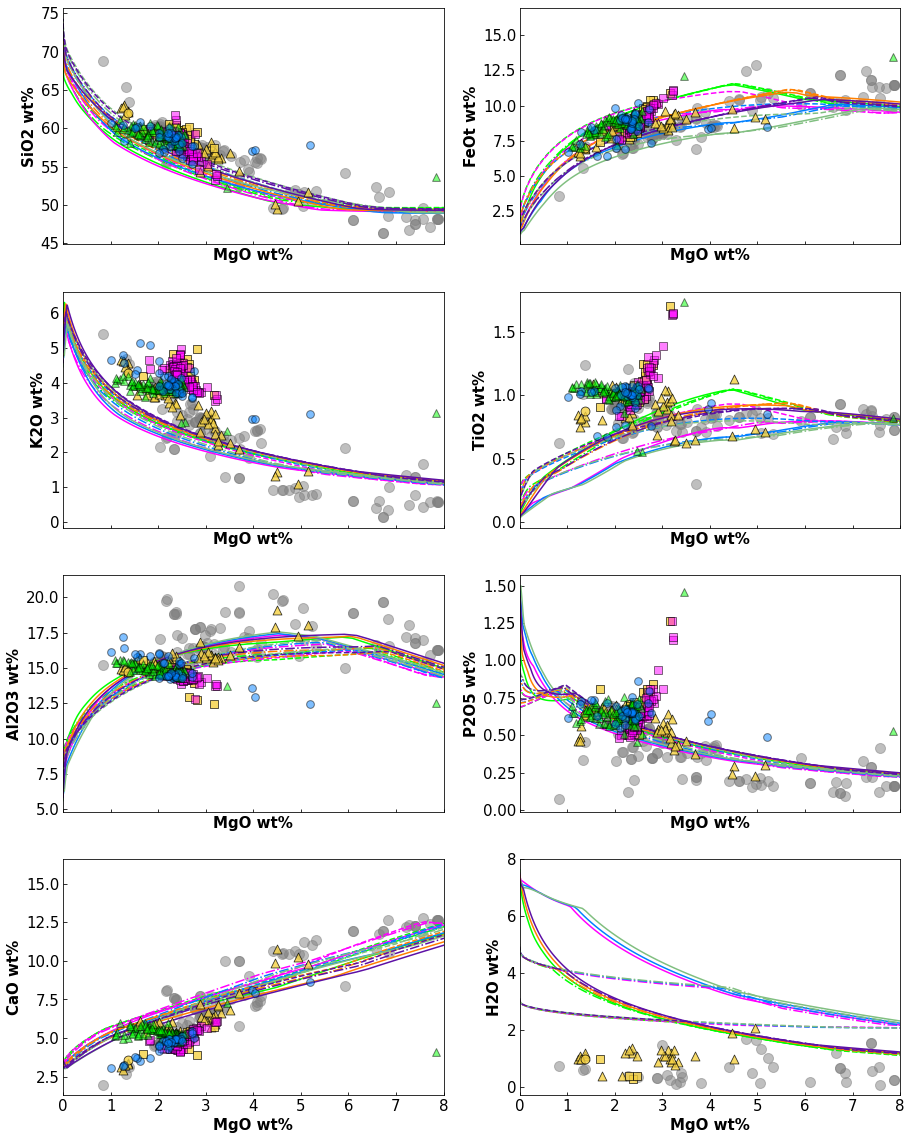

In [96]:
fig, ax = plt.subplots(4,2, sharex = True)
fig.set_figheight(20)
fig.set_figwidth(15)
plt.rcParams["font.family"] ="sans-serif" 
plt.rcParams["font.size"] = 12


for v in volbudg:
    df_v = play[play.newcolumn == v]
    for p in pressure:
        df_vp = df_v[df_v.pressure_bar == p]
        
        x = df_vp['MgO_Liq']
        ax[0,0].plot(x, df_vp['SiO2_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[0,1].plot(x, df_vp['FeOt_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[1,0].plot(x, df_vp['K2O_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[1,1].plot(x, df_vp['TiO2_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[2,0].plot(x, df_vp['Al2O3_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[2,1].plot(x, df_vp['P2O5_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[3,0].plot(x, df_vp['CaO_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[3,1].plot(x, df_vp['H2O_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])

        
# Natural data           
# Construct symbol dictionary for MI hosts
host = ['ol', 'cpx', 'plag']
symb = ['^', 'o', 's']
symbmap = dict(zip(host, symb))

df_wr = (yas_dat[yas_dat.Data_Type == 'WR'])

x = df_wr['MgO']
ax[0,0].scatter(x, df_wr['SiO2'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[0,1].scatter(x, df_wr['FeOt'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[1,0].scatter(x, df_wr['K2O'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[1,1].scatter(x, df_wr['TiO2'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[2,0].scatter(x, df_wr['Al2O3'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[2,1].scatter(x, df_wr['P2O5'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')         
ax[3,0].scatter(x, df_wr['CaO'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[3,1].scatter(x, df_wr['H2O+'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')   



#plotting MI data
for i in host: 
    df0 = vandat[vandat['Island']=='Yasur']
    dfhost = df0[df0['Host'] == i]
    x = dfhost['MgO']
    ax[0,0].scatter(x, dfhost['SiO2'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[0,1].scatter(x, dfhost['FeOt'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[1,0].scatter(x, dfhost['K2O'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[1,1].scatter(x, dfhost['TiO2'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[2,0].scatter(x, dfhost['Al2O3'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[2,1].scatter(x, dfhost['P2O5'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[3,0].scatter(x, dfhost['CaO'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[3,1].scatter(x, dfhost['H2O+'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    #ax[3,1].legend()
# Plotting EPMA Data
for b in yas_mi['Min_Host'].unique():
    our_data = yas_mi[yas_mi.Min_Host == b]
        
    x = our_data['MgO']
    
    ax[0,0].scatter(x, our_data['SiO2'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[0,1].scatter(x, our_data['FeO'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[1,0].scatter(x, our_data['K2O'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[1,1].scatter(x, our_data['TiO2'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[2,0].scatter(x, our_data['Al2O3'],color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[2,1].scatter(x, our_data['P2O5'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[3,0].scatter(x, our_data['CaO'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
      
        
ax = ax.flatten()
for i in range(8):
    ax[i].tick_params(axis='both', which='both', labelsize=15, direction='in')
    ax[i].set_xlim(0,8)
    ax[i].set_xlabel('MgO wt%', fontsize=15,weight='bold')
    if i == 0:
        ax[i].set_ylabel('SiO2 wt%', fontsize=15, weight='bold')
    if i == 1:
        ax[i].set_ylabel('FeOt wt%', fontsize=15, weight='bold')
    if i == 2:
        ax[i].set_ylabel('K2O wt%', fontsize=15, weight='bold')
    if i == 3:
        ax[i].set_ylabel('TiO2 wt%', fontsize=15, weight='bold')
    if i == 4:
        ax[i].set_ylabel('Al2O3 wt%', fontsize=15, weight='bold')
    if i == 5:
        ax[i].set_ylabel('P2O5 wt%', fontsize=15, weight='bold')
    if i == 6:
        ax[i].set_ylabel('CaO wt%', fontsize=15, weight='bold')
    if i == 7:
        ax[i].set_ylabel('H2O wt%', fontsize=15, weight='bold')




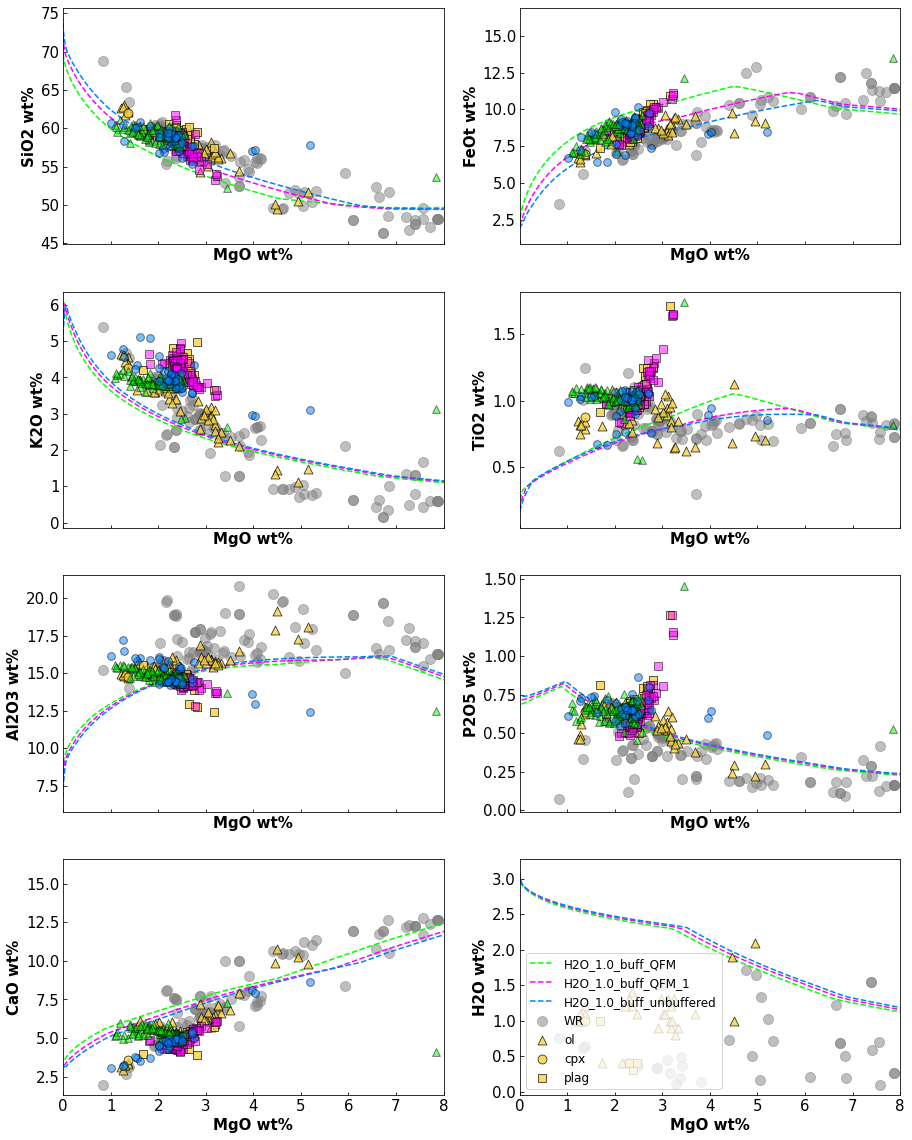

In [99]:
water_2 = play[play.unique.str.contains('H2O_1.0_')]

#example = distinctipy.get_colors(32)
#colors = example
volbudg = water_2['newcolumn'].unique()
scalarMap2 = dict(zip(volbudg, colors))

pressure = [500]

fig, ax = plt.subplots(4,2, sharex = True)
fig.set_figheight(20)
fig.set_figwidth(15)
plt.rcParams["font.family"] ="sans-serif" 
plt.rcParams["font.size"] = 12


for v in water_2['newcolumn'].unique():
    df_v = water_2[water_2.newcolumn == v]
    for p in pressure:
        df_vp = df_v[df_v.pressure_bar == p]
        
        x = df_vp['MgO_Liq']
        ax[0,0].plot(x, df_vp['SiO2_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[0,1].plot(x, df_vp['FeOt_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[1,0].plot(x, df_vp['K2O_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[1,1].plot(x, df_vp['TiO2_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[2,0].plot(x, df_vp['Al2O3_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[2,1].plot(x, df_vp['P2O5_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[3,0].plot(x, df_vp['CaO_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[3,1].plot(x, df_vp['H2O_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])

        
# Natural data           
# Construct symbol dictionary for MI hosts
host = ['ol', 'cpx', 'plag']
symb = ['^', 'o', 's']
symbmap = dict(zip(host, symb))

df_wr = (yas_dat[yas_dat.Data_Type == 'WR'])

x = df_wr['MgO']
ax[0,0].scatter(x, df_wr['SiO2'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[0,1].scatter(x, df_wr['FeOt'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[1,0].scatter(x, df_wr['K2O'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[1,1].scatter(x, df_wr['TiO2'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[2,0].scatter(x, df_wr['Al2O3'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[2,1].scatter(x, df_wr['P2O5'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')         
ax[3,0].scatter(x, df_wr['CaO'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[3,1].scatter(x, df_wr['H2O+'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')   
ax[3,1].legend()


#plotting MI data
for i in host: 
    df0 = vandat[vandat['Island']=='Yasur']
    dfhost = df0[df0['Host'] == i]
    x = dfhost['MgO']
    ax[0,0].scatter(x, dfhost['SiO2'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[0,1].scatter(x, dfhost['FeOt'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[1,0].scatter(x, dfhost['K2O'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[1,1].scatter(x, dfhost['TiO2'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[2,0].scatter(x, dfhost['Al2O3'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[2,1].scatter(x, dfhost['P2O5'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[3,0].scatter(x, dfhost['CaO'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[3,1].scatter(x, dfhost['H2O+'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[3,1].legend()
# Plotting EPMA Data
for b in yas_mi['Min_Host'].unique():
    our_data = yas_mi[yas_mi.Min_Host == b]
        
    x = our_data['MgO']
    
    ax[0,0].scatter(x, our_data['SiO2'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[0,1].scatter(x, our_data['FeO'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[1,0].scatter(x, our_data['K2O'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[1,1].scatter(x, our_data['TiO2'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[2,0].scatter(x, our_data['Al2O3'],color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[2,1].scatter(x, our_data['P2O5'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[3,0].scatter(x, our_data['CaO'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
      
        
ax = ax.flatten()
for i in range(8):
    ax[i].tick_params(axis='both', which='both', labelsize=15, direction='in')
    ax[i].set_xlim(0,8)
    ax[i].set_xlabel('MgO wt%', fontsize=15,weight='bold')
    if i == 0:
        ax[i].set_ylabel('SiO2 wt%', fontsize=15, weight='bold')
    if i == 1:
        ax[i].set_ylabel('FeOt wt%', fontsize=15, weight='bold')
    if i == 2:
        ax[i].set_ylabel('K2O wt%', fontsize=15, weight='bold')
    if i == 3:
        ax[i].set_ylabel('TiO2 wt%', fontsize=15, weight='bold')
    if i == 4:
        ax[i].set_ylabel('Al2O3 wt%', fontsize=15, weight='bold')
    if i == 5:
        ax[i].set_ylabel('P2O5 wt%', fontsize=15, weight='bold')
    if i == 6:
        ax[i].set_ylabel('CaO wt%', fontsize=15, weight='bold')
    if i == 7:
        ax[i].set_ylabel('H2O wt%', fontsize=15, weight='bold')

In [667]:
play2 = mast_df[mast_df.melt_f > 0.15] 
#funky behaviour at low melt fraction where melt is becoming unsaturated in sulfide again 

{'H2O_1.0_buff_QFM': (0.0, 1.0, 0.0), 'H2O_2.0_buff_QFM': (0.9293443428660777, 0.0018104197903582309, 0.9917428605028196), 'H2O_2.0_buff_QFM_1': (0.007769413921184354, 0.5446395690560026, 0.9985177134399151), 'H2O_1.0_buff_QFM_1': (1.0, 0.5, 0.0), 'H2O_2.0_buff_unbuffered': (0.31093821002021227, 0.49714904229446744, 0.3170722527234161), 'H2O_1.0_buff_unbuffered': (0.09851610456230542, 0.02048801928940036, 0.7047820556457403)}
{2000: 'solid', 1000: 'dashdot', 500: 'dashed'}


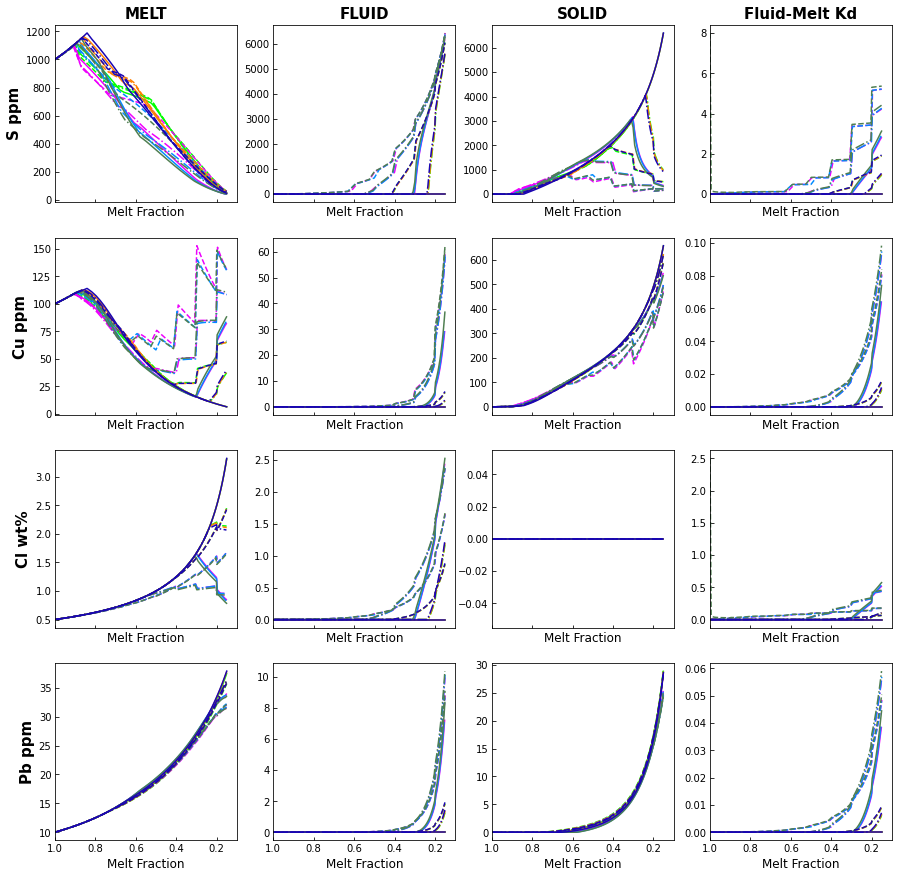

In [668]:
# Metal concentration plots
fig, ax = plt.subplots(4,4, sharex = True)
ax[0,0].invert_xaxis()
fig.set_figheight(15)
fig.set_figwidth(15)
plt.rcParams["font.family"] ="sans-serif" 
plt.rcParams["font.size"] = 12

print(scalarMap2)
print(pdict)
for v in volbudg:
    df_v = play2[play2.newcolumn == v]
    for p in pressure:
        df_vp = df_v[df_v.pressure_bar == p]
        
        x = df_vp['melt_f']
        ax[0,0].plot(x, df_vp['melt_S_sulf'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[0,1].plot(x, df_vp['fluid_S'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[0,2].plot(x, df_vp['solid_S'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[1,0].plot(x, df_vp['melt_Cu'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[1,1].plot(x, df_vp['fluid_Cu'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[1,2].plot(x, df_vp['solid_Cu'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[2,0].plot(x, df_vp['melt_Cl'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[2,1].plot(x, df_vp['fluid_Cl'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[2,2].plot(x, df_vp['solid_Cl'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[3,0].plot(x, df_vp['melt_Pb'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[3,1].plot(x, df_vp['fluid_Pb'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[3,2].plot(x, df_vp['solid_Pb'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        
        #Fluid-Melt Partitioning behaviour
        ax[0,3].plot(x, df_vp['bulk_DS'], color=scalarMap2[v], label='DS', linestyle=pdict[p])
        ax[2,3].plot(x, df_vp['bulk_DCl'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[1,3].plot(x, df_vp['bulk_DCu_fm'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[3,3].plot(x, df_vp['bulk_DPb_fm'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        
        #ax[0,3].plot(x, df_vp['DS_xxm'], color='k', label=v, linestyle=pdict[p])
        #ax[2,3].plot(x, df_vp['bulk_DCl_xxm'], color='k', label=v, linestyle=pdict[p])
        #ax[1,3].plot(x, df_vp['bulk_DCu_xxm'], color='k', label=v, linestyle=pdict[p])
        #ax[3,3].plot(x, df_vp['bulk_DPb_xxm'], color='k', label=v, linestyle=pdict[p])
        
        #ax[3,2].legend()

    
        
ax = ax.flatten()
for i in range(16):
    ax[i].tick_params(axis='both', which='both', labelsize=10, direction='in')
    ax[i].set_xlim(1,0.1)
    ax[i].set_xlabel('Melt Fraction', fontsize=12,weight='normal')
    if i == 0:
        ax[i].set_ylabel('S ppm', fontsize=15, weight='bold')
        ax[i].set_title('MELT', fontsize=15, weight='bold')
    if i == 4:
        ax[i].set_ylabel('Cu ppm', fontsize=15, weight='bold')
    if i == 8:
        ax[i].set_ylabel('Cl wt%', fontsize=15, weight='bold')
    if i == 1:
        ax[i].set_title('FLUID', fontsize=15, weight='bold')
    if i == 2:
        ax[i].set_title('SOLID', fontsize=15, weight='bold')
    if i == 3:
        ax[i].set_title('Fluid-Melt Kd', fontsize=15, weight='bold')
    if i == 12:
        ax[i].set_ylabel('Pb ppm', fontsize=15, weight='bold')


In [359]:
search_df = play[play['unique'].str.contains('_H2O_2.0_')]
search_df.to_excel('_H2O_2.0_.xlsx')

{'P_2000.0_H2O_2.0_CO2_0.01_buff_QFM': (0.0, 1.0, 0.0), 'P_2000.0_H2O_2.0_CO2_0.01_buff_unbuffered': (1.0, 0.0, 1.0), 'P_2000.0_H2O_2.0_CO2_0.1_buff_QFM': (0.0, 0.5, 1.0), 'P_2000.0_H2O_2.0_CO2_0.1_buff_unbuffered': (1.0, 0.5, 0.0), 'P_500.0_H2O_2.0_CO2_0.01_buff_QFM': (0.5, 0.75, 0.5), 'P_500.0_H2O_2.0_CO2_0.1_buff_QFM': (0.4068479383765278, 0.12278448515815743, 0.593407444426754), 'P_500.0_H2O_2.0_CO2_0.1_buff_unbuffered': (0.7291696669554278, 0.029002546534238505, 0.04549902834503394)}


KeyError: 'P_500.0_H2O_2.0_CO2_0.01_buff_unbuffered'

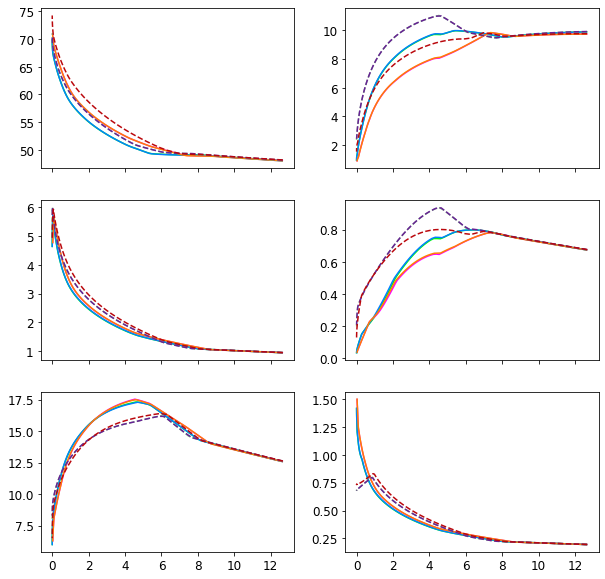

In [360]:
#search_df = mast_df[mast_df.unique.isin(['P_2000.0_H2O_2.0_CO2_0.01_buff_QFM',
 #      'P_2000.0_H2O_2.0_CO2_0.01_buff_unbuffered','P_2000.0_H2O_2.0_CO2_0.1_buff_QFM','P_2000.0_H2O_2.0_CO2_0.1_buff_unbuffered',
  #     'P_2000.0_H2O_1.0_CO2_0.01_buff_unbuffered',
   #    'P_2000.0_H2O_1.0_CO2_0.1_buff_QFM',
    #   'P_2000.0_H2O_1.0_CO2_0.1_buff_unbuffered'])]



example = distinctipy.get_colors(7)
colors = example
volbudg = search_df['unique'].unique()
scalarMap2 = dict(zip(volbudg, colors))
print(scalarMap2)

# Major element plots
fig, ax = plt.subplots(3,2, sharex = True)
fig.set_figheight(10)
fig.set_figwidth(10)
plt.rcParams["font.family"] ="sans-serif" 
plt.rcParams["font.size"] = 12

# dict for linestyle
pressure = search_df['pressure_bar'].unique()
lines = ['solid', 'dashed', 'dashdot','dashed']
pdict = dict(zip(pressure, lines))

for v in volbudg:
    df_v = search_df[search_df.unique == v]
    for p in pressure:
        df_vp = df_v[df_v.pressure_bar == p]
        
        x = df_vp['MgO_Liq']
        ax[0,0].plot(x, df_vp['SiO2_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[0,1].plot(x, df_vp['FeOt_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[1,0].plot(x, df_vp['K2O_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[1,1].plot(x, df_vp['TiO2_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[2,0].plot(x, df_vp['Al2O3_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[2,1].plot(x, df_vp['P2O5_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        
        
# Natural data           
# Construct symbol dictionary for MI hosts
host = ['ol', 'cpx', 'plag']
symb = ['^', 'o', 's']
symbmap = dict(zip(host, symb))

df_wr = (yas_dat[yas_dat.Data_Type == 'WR'])

x = df_wr['MgO']
ax[0,0].scatter(x, df_wr['SiO2'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[0,1].scatter(x, df_wr['FeOt'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[1,0].scatter(x, df_wr['K2O'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[1,1].scatter(x, df_wr['TiO2'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[2,0].scatter(x, df_wr['Al2O3'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')
ax[2,1].scatter(x, df_wr['P2O5'], color='grey', marker='o', s=100, alpha=0.5, zorder=1, label='WR')         


#plotting MI data
for i in host: 
    df0 = vandat[vandat['Island']=='Yasur']
    dfhost = df0[df0['Host'] == i]
    x = dfhost['MgO']
    ax[0,0].scatter(x, dfhost['SiO2'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[0,1].scatter(x, dfhost['FeOt'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[1,0].scatter(x, dfhost['K2O'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[1,1].scatter(x, dfhost['TiO2'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[2,0].scatter(x, dfhost['Al2O3'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    ax[2,1].scatter(x, dfhost['P2O5'], color='#f5d142',marker=symbmap[i],s=80,alpha=0.8, linewidths=0.8, edgecolors='black', label=i, zorder=2)
    
# Plotting EPMA Data
for b in yas_mi['Min_Host'].unique():
    our_data = yas_mi[yas_mi.Min_Host == b]
        
    x = our_data['MgO']
    
    ax[0,0].scatter(x, our_data['SiO2'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[0,1].scatter(x, our_data['FeO'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[1,0].scatter(x, our_data['K2O'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[1,1].scatter(x, our_data['TiO2'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[2,0].scatter(x, our_data['Al2O3'],color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
    ax[2,1].scatter(x, our_data['P2O5'], color=probe_cdict[b], marker=probe_symdict[b],alpha=0.5, edgecolor='k',s=60, label=x, zorder=3)
        
ax = ax.flatten()
for i in range(6):
    ax[i].tick_params(axis='both', which='both', labelsize=15, direction='in')
    ax[i].set_xlim(0,12.5)
    ax[i].set_xlabel('MgO wt%', fontsize=15,weight='bold')
    if i == 0:
        ax[i].set_ylabel('SiO2 wt%', fontsize=15, weight='bold')
    if i == 1:
        ax[i].set_ylabel('FeOt wt%', fontsize=15, weight='bold')
    if i == 2:
        ax[i].set_ylabel('K2O wt%', fontsize=15, weight='bold')
    if i == 3:
        ax[i].set_ylabel('TiO2 wt%', fontsize=15, weight='bold')
    if i == 4:
        ax[i].set_ylabel('Al2O3 wt%', fontsize=15, weight='bold')
    if i == 5:
        ax[i].set_ylabel('P2O5 wt%', fontsize=15, weight='bold')

In [ ]:
mast_df = mast_df.loc[:173]

x = mast_df['melt_f']

y = mast_df['melt_S_sulf']

x2 = mast_df['MgO_Liq']

fig, ax1 = plt.subplots()
ax1.get_shared_y_axes().join(ax1,ax2)
ax2 = ax1.twiny()
ax1.scatter(x,y, c='r')
ax2.scatter(x2,y)



In [ ]:
mast_df[['unique','melt_f','melt_S_sulf', 'MgO_Liq']].to_excel('check.xlsx')

In [ ]:
x = mast_df['melt_f']

y = mast_df['melt_S_sulf']

x2 = mast_df['MgO_Liq']

fig, ax1 = plt.subplots()

ax1.scatter(x,y)


In [ ]:
lambda a : a
modsyst_mass = syst_mass.apply(lambda a : a * 10)

### Plotting for Rhiannon 

In [ ]:
rhi_df = pd.read_excel('/Users/ollie/Rhiannon_MELTS/gleesonFC_simulation_output.xlsx')

In [ ]:
model = rhi_df.drop(['Unnamed: 0', 'index'], axis=1)
model

In [ ]:
model.newcolumn.unique()

In [ ]:
example = distinctipy.get_colors(2)
distinctipy.color_swatch(example)
# dict for colour
colors = example#[i for i in get_cmap('tab20b').colors]
volbudg = metal_model['unique'].unique()
scalarMap2 = dict(zip(volbudg, colors))
print(scalarMap2)

In [ ]:
empty_na = model.copy()
empty_na = model[model.P_bar.isin([2000])]

#set up plot
fig, ax = plt.subplots(3,2, sharex = True)
fig.set_figheight(15)
fig.set_figwidth(10)
plt.rcParams["font.family"] ="sans-serif" 
plt.rcParams["font.size"] = 12

# dict for colour
colors = example#[i for i in get_cmap('tab20b').colors]
volbudg = empty_na['newcolumn'].unique()
scalarMap2 = dict(zip(volbudg, colors))

# dict for linestyle
pressure = empty_na['P_bar'].unique()
lines = ['solid', 'dashed', 'dashdot','dashed']
pdict = dict(zip(pressure, lines))

for v in volbudg:
    df_v = empty_na[empty_na.newcolumn == v]
    for p in pressure:
        df_vp = df_v[df_v.P_bar == p]
        
        x = df_vp['MgO_Liq']
        ax[0,0].plot(x, df_vp['SiO2_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[0,1].plot(x, df_vp['FeOt_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[1,0].plot(x, df_vp['K2O_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[1,1].plot(x, df_vp['TiO2_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[2,0].plot(x, df_vp['Al2O3_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[2,1].plot(x, df_vp['SiO2_Liq'], color=scalarMap2[v], label=v, linestyle=pdict[p])
        ax[2,1].legend()
        
ax = ax.flatten()
for i in range(6):
    ax[i].tick_params(axis='both', which='both', labelsize=15, direction='in')
    ax[i].set_xlim(0,10)
    ax[i].set_xlabel('MgO wt%', fontsize=15,weight='bold')
    if i == 0:
        ax[i].set_ylabel('SiO2 wt%', fontsize=15, weight='bold')
    if i == 1:
        ax[i].set_ylabel('FeOt wt%', fontsize=15, weight='bold')
    if i == 2:
        ax[i].set_ylabel('K2O wt%', fontsize=15, weight='bold')
    if i == 3:
        ax[i].set_ylabel('TiO2 wt%', fontsize=15, weight='bold')
    if i == 4:
        ax[i].set_ylabel('Al2O3 wt%', fontsize=15, weight='bold')
        ax[i].set_ylim(10, 17)
        ax[i].set_xlim(0, 20)
    if i == 5:
        ax[i].set_ylabel('SiO2 wt%', fontsize=15, weight='bold')

In [ ]:
water = empty_na.newcolumn.unique()

for i in water:
    newdf = empty_na[empty_na.newcolumn == i]
    
    plt.plot(newdf.MgO_Liq, newdf.Al2O3_Liq)
plt.legend()


In [ ]:
water5 = empty_na[empty_na.newcolumn.isin(['H2O_0.5_buff_unbuffered'])]

In [ ]:
plt.plot(water5.MgO_Liq, water5.Al2O3_Liq)